<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-and-preparing-data" data-toc-modified-id="Loading-and-preparing-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading and preparing data</a></span></li><li><span><a href="#Differences-in-color-semantics-between-sighted-and-blind-in-combined-data" data-toc-modified-id="Differences-in-color-semantics-between-sighted-and-blind-in-combined-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Differences in color semantics between sighted and blind in combined data</a></span><ul class="toc-item"><li><span><a href="#COCA-fiction" data-toc-modified-id="COCA-fiction-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>COCA-fiction</a></span></li><li><span><a href="#COCA-fiction-without-1st-order-cooccurrence-of-color-and-dimension-words" data-toc-modified-id="COCA-fiction-without-1st-order-cooccurrence-of-color-and-dimension-words-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>COCA-fiction without 1st order cooccurrence of color and dimension words</a></span></li><li><span><a href="#COCA-fiction-without-100-nearest-neighbors-of-each-dimension-word" data-toc-modified-id="COCA-fiction-without-100-nearest-neighbors-of-each-dimension-word-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>COCA-fiction without 100 nearest neighbors of each dimension word</a></span></li><li><span><a href="#COCA-fiction-without-names-provided-by-participants-for-color-semantic-dimensions" data-toc-modified-id="COCA-fiction-without-names-provided-by-participants-for-color-semantic-dimensions-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>COCA-fiction without names provided by participants for color-semantic dimensions</a></span></li></ul></li><li><span><a href="#Convert-notebook-to-html" data-toc-modified-id="Convert-notebook-to-html-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Convert notebook to html</a></span></li></ul></div>

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.display import display, display_markdown

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import subprocess as sp
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import bambi
from copy import deepcopy

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['figure.dpi'] = 150

from subs2vec.utensils import log_timer
from subs2vec.vecs import Vectors
from subs2vec.neighbors import compute_nn

import logging
logging.getLogger().setLevel(logging.WARNING)

def display_md(md, **kwargs):
    return display_markdown(md, raw=True, **kwargs)

def convert_notebook(title, output='html'):
    convert = sp.run(f'jupyter nbconvert {title}.ipynb --to {output} --output {title}.{output}'.split(' '))
    if convert.returncode == 0:
        display_md(f'Jupyter notebook `{title}` converted successfully.')
    else:
        display_md(f'Error: encountered problem converting Jupyter notebook `{title}`')

def norm(x):
    return x / np.linalg.norm(x, 2)

def standardize(x):
    return (x - x.mean()) / x.std()

sns.set(style='whitegrid')
pd.options.mode.chained_assignment = None

# Loading and preparing data

In [2]:
df_joint = pd.read_csv('data/data_plus_predictors.tsv', sep='\t')
display(df_joint)

index    group              dimension          pp_id  color  rating  \
0          0  sighted               cold-hot      sighted_1  white       1   
1          1  sighted            ripe-unripe      sighted_1  white       7   
2          2  sighted                new-old      sighted_1  white       1   
3          3  sighted  submissive-aggressive      sighted_1  white       1   
4          4  sighted       selfless-jealous      sighted_1  white       1   
...      ...      ...                    ...            ...    ...     ...   
42975  28507  sighted            light-heavy  sighted_68129    red       5   
42976  28508  sighted          relaxed-tense  sighted_68129    red       5   
42977  28509  sighted             alive-dead  sighted_68129    red       6   
42978  28510  sighted              fast-slow  sighted_68129    red       3   
42979  28511  sighted               high-low  sighted_68129    red       2   

          experiment self_vs_other   art  fiction  ...  sighted  group_eff  \
0           original          self   NaN      NaN  ...        1        1.0   
1           original          self   NaN      NaN  ...        1        1.0   
2           original          self   NaN      NaN  ...        1        1.0   
3           original          self   NaN      NaN  ...        1        1.0   
4           original          self   NaN      NaN  ...        1        1.0   
...              ...           ...   ...      ...  ...      ...        ...   
42975  replication_2         other  11.0      0.0  ...        1        1.0   
42976  replication_2         other  11.0      0.0  ...        1        1.0   
42977  replication_2         other  11.0      0.0  ...        1        1.0   
42978  replication_2         other  11.0      0.0  ...        1        1.0   
42979  replication_2         other  11.0      0.0  ...        1        1.0   

        group_z  original  replication_1  replication_2 other self  \
0      0.211241         1              0              0     0    1   
1      0.211241         1              0              0     0    1   
2      0.211241         1              0              0     0    1   
3      0.211241         1              0              0     0    1   
4      0.211241         1              0              0     0    1   
...         ...       ...            ...            ...   ...  ...   
42975  0.211241         0              0              1     1    0   
42976  0.211241         0              0              1     1    0   
42977  0.211241         0              0              1     1    0   
42978  0.211241         0              0              1     1    0   
42979  0.211241         0              0              1     1    0   

       self_vs_other_eff  self_vs_other_z  
0                   -1.0        -0.891882  
1                   -1.0        -0.891882  
2                   -1.0        -0.891882  
3                   -1.0        -0.891882  
4                   -1.0        -0.891882  
...                  ...              ...  
42975                1.0         1.121199  
42976                1.0         1.121199  
42977                1.0         1.121199  
42978                1.0         1.121199  
42979                1.0         1.121199  

[42980 rows x 74 columns]

In [3]:
corr = df_joint[['cosine_fic_z', 'cosine_fic_filtered_z', 'cosine_fic_nonames_z', 'cosine_fic_noneighbors_z']].corr()
display(corr.round(2))

cosine_fic_z  cosine_fic_filtered_z  \
cosine_fic_z                      1.00                   0.90   
cosine_fic_filtered_z             0.90                   1.00   
cosine_fic_nonames_z              0.41                   0.36   
cosine_fic_noneighbors_z          0.68                   0.65   

                          cosine_fic_nonames_z  cosine_fic_noneighbors_z  
cosine_fic_z                              0.41                      0.68  
cosine_fic_filtered_z                     0.36                      0.65  
cosine_fic_nonames_z                      1.00                      0.27  
cosine_fic_noneighbors_z                  0.27                      1.00

# Differences between modified versions of the COCA-fiction corpus

## COCA-fiction

In [5]:
m_fic = bambi.Model('rating_z ~ 1'
    + ' + group_eff*frequency_z'
    + ' + group_eff*concreteness_z'
    + ' + group_eff*cosine_fic_z'
    + ' + group_eff*swow_all_z'
    + ' + (1 + frequency_z + concreteness_z + cosine_fic_z + swow_all_z|pp_id)'
    + ' + (1 + group_eff|dimension)'
    + ' + (1 + group_eff|color)',
    df_joint[df_joint['self_vs_other'] == 'self']
)
r_fic = m_fic.fit(
    init='advi+adapt_diag',
    chains=4,
    draws=1000,
    tune=1000,
    n_init=10000,
    target_accept=.95,
)

Auto-assigning NUTS sampler...
[INFO] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
[INFO] Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 42,930
[INFO] Finished [100%]: Average Loss = 42,930
Multiprocess sampling (4 chains in 4 jobs)
[INFO] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, group_eff, frequency_z, group_eff:frequency_z, concreteness_z, group_eff:concreteness_z, cosine_fic_z, group_eff:cosine_fic_z, swow_all_z, group_eff:swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequency_z|pp_id_offset, concreteness_z|pp_id_sigma, concreteness_z|pp_id_offset, cosine_fic_z|pp_id_sigma, cosine_fic_z|pp_id_offset, swow_all_z|pp_id_sigma, swow_all_z|pp_id_offset, 1|dimension_sigma, 1|dimension_offset, group_eff|dimension_sigma, group_eff|dimension_offset, 1|color_sigma, 1|color_offset, group_eff|color_sigma, group_eff|color_offset, rating_z_sigma]
[INFO] NUTS: [Intercept, group_eff, frequency_z, group_eff:frequency_z, concreteness_z, group_eff:concreteness_z, cosine_fic_z, group_eff:cosine_fic_z, swow_all_z, group_eff:swow_all_z, 1|pp_id_sigma, 1|pp_id_offse

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1423 seconds.
[INFO] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1423 seconds.


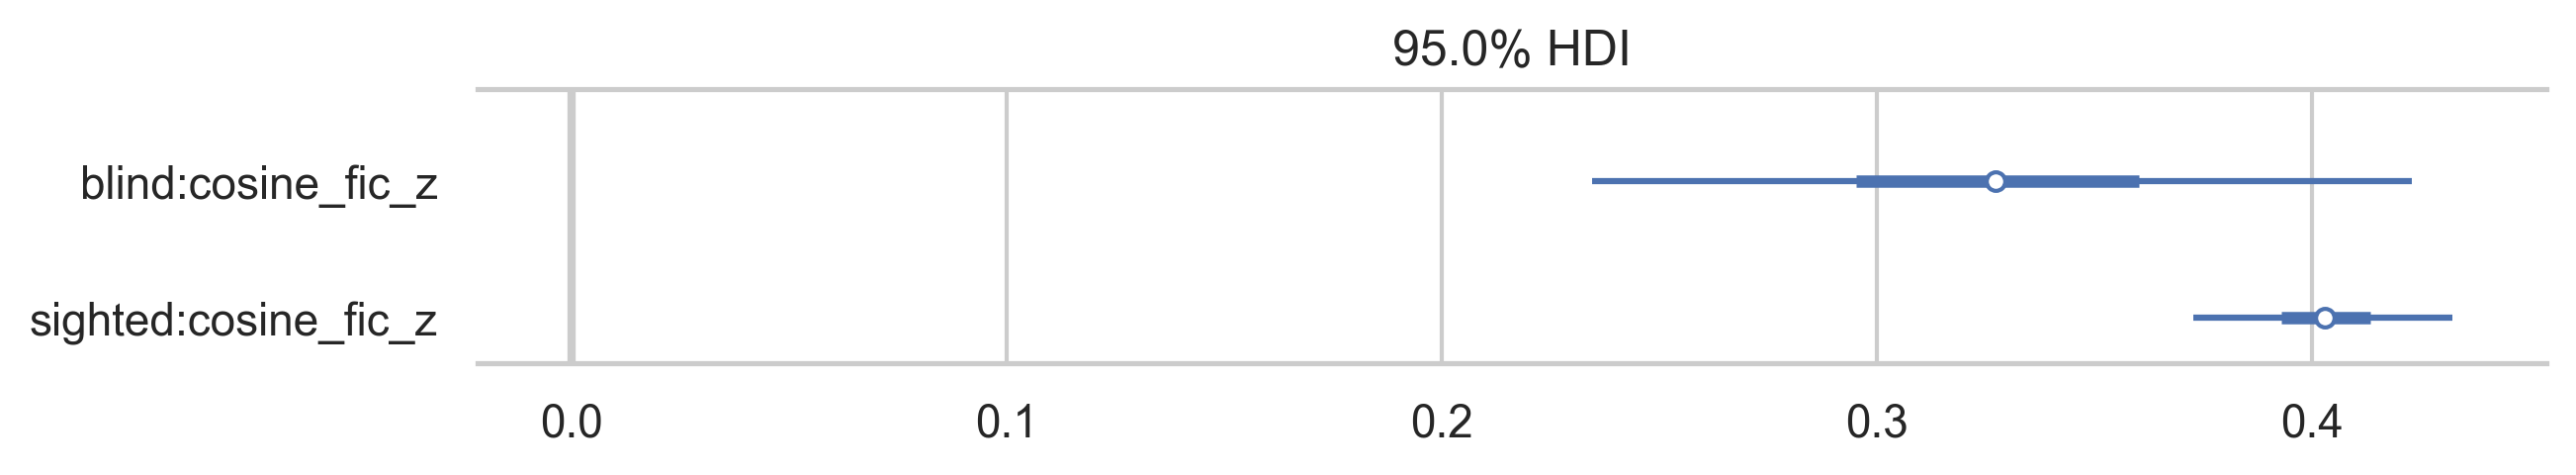

In [5]:
# compute and plot conditional effect of cosine in sighted and blind groups
trace = deepcopy(r_fic.posterior)
# effect of cosine in blind group in orginal experiment
trace['blind:cosine_fic_z'] = trace['cosine_fic_z'] - trace['group_eff:cosine_fic_z']
    # effect of cosine in sighted group across both experiments
trace['sighted:cosine_fic_z'] = trace['cosine_fic_z'] + trace['group_eff:cosine_fic_z']

varnames = ['blind:cosine_fic_z', 'sighted:cosine_fic_z']
g = az.plot_forest(trace, combined=True, hdi_prob=.95,
                   figsize=[9, .6 + len(varnames) * .3],
                   var_names=varnames)
g[0].axvline(0, color='.8', linewidth=2);

## COCA-fiction without 1st order cooccurrence of color and dimension words

In [4]:
m_fic_filtered = bambi.Model('rating_z ~ 1'
    + ' + group_eff*frequency_z'
    + ' + group_eff*concreteness_z'
    + ' + group_eff*cosine_fic_filtered_z'
    + ' + group_eff*swow_all_z'
    + ' + (1 + frequency_z + concreteness_z + cosine_fic_filtered_z + swow_all_z|pp_id)'
    + ' + (1 + group_eff|dimension)'
    + ' + (1 + group_eff|color)',
    df_joint[df_joint['self_vs_other'] == 'self']
)
r_fic_filtered = m_fic_filtered.fit(
    init='advi+adapt_diag',
    chains=4,
    draws=1000,
    tune=1000,
    n_init=10000,
    target_accept=.95,
)

Auto-assigning NUTS sampler...
[INFO] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
[INFO] Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 42,755
[INFO] Finished [100%]: Average Loss = 42,755
Multiprocess sampling (4 chains in 4 jobs)
[INFO] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, group_eff, frequency_z, group_eff:frequency_z, concreteness_z, group_eff:concreteness_z, cosine_fic_filtered_z, group_eff:cosine_fic_filtered_z, swow_all_z, group_eff:swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequency_z|pp_id_offset, concreteness_z|pp_id_sigma, concreteness_z|pp_id_offset, cosine_fic_filtered_z|pp_id_sigma, cosine_fic_filtered_z|pp_id_offset, swow_all_z|pp_id_sigma, swow_all_z|pp_id_offset, 1|dimension_sigma, 1|dimension_offset, group_eff|dimension_sigma, group_eff|dimension_offset, 1|color_sigma, 1|color_offset, group_eff|color_sigma, group_eff|color_offset, rating_z_sigma]
[INFO] NUTS: [Intercept, group_eff, frequency_z, group_eff:frequency_z, concreteness_z, group_eff:concreteness_z, cosine_fic_filtered_z, group_eff:cosine_fic_filtered_z, swow_all

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1496 seconds.
[INFO] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1496 seconds.


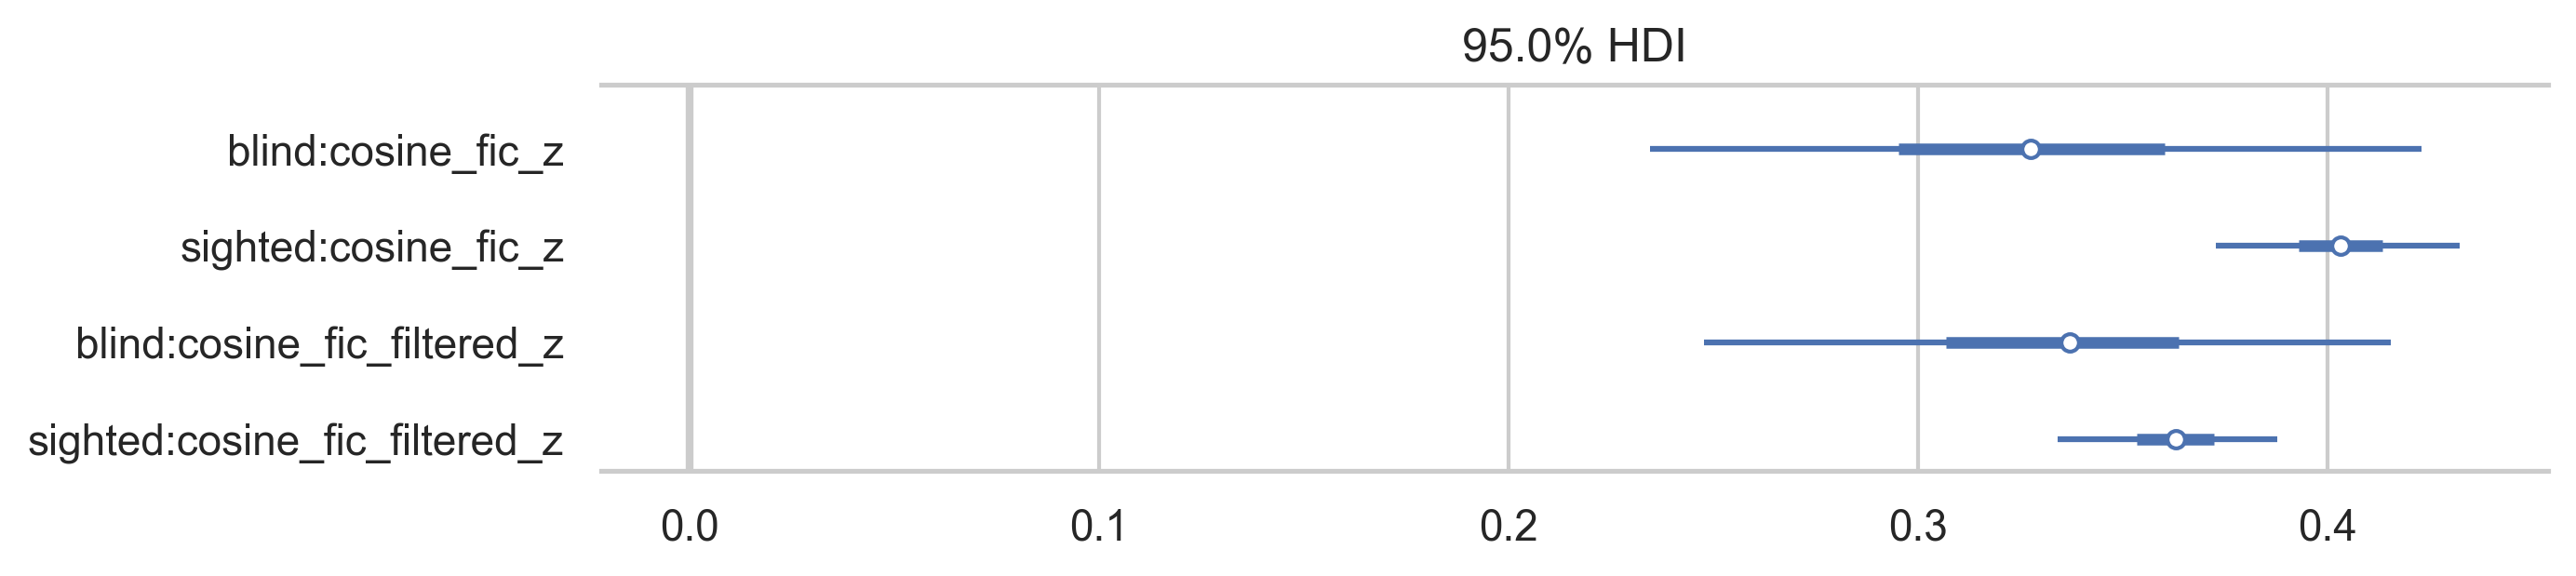

In [7]:
# compute and plot conditional effect of cosine in sighted and blind groups
trace_filtered = deepcopy(r_fic_filtered.posterior)
# effect of cosine in blind group in orginal experiment
trace['blind:cosine_fic_filtered_z'] = trace_filtered['cosine_fic_filtered_z'] - trace_filtered['group_eff:cosine_fic_filtered_z']
# effect of cosine in sighted group across both experiments
trace['sighted:cosine_fic_filtered_z'] = trace_filtered['cosine_fic_filtered_z'] + trace_filtered['group_eff:cosine_fic_filtered_z']

varnames = [
    'blind:cosine_fic_z', 'sighted:cosine_fic_z',
    'blind:cosine_fic_filtered_z', 'sighted:cosine_fic_filtered_z',
]
g = az.plot_forest(trace, combined=True, hdi_prob=.95,
                   figsize=[9, .6 + len(varnames) * .3],
                   var_names=varnames)
g[0].axvline(0, color='.8', linewidth=2);

## COCA-fiction without 100 nearest neighbors of each dimension word
Filtering out the 100 nearest neighbors of each dimension word filters out a large number of sentences that include the dimension words themselves, which mean some of the dimension words are no longer represented in the word embeddings (i.e. not just degraded representations, but no vector at all). For the COCA-fiction corpus, the number of dimensions that is no longer attested is small and so we have simply replaced these NAs with zeros for this analysis. (As we will see below, this presents a larger problem for the COCA-spoken corpus.)

In [4]:
m_fic_noneighbors = bambi.Model('rating_z ~ 1'
    + ' + group_eff*frequency_z'
    + ' + group_eff*concreteness_z'
    + ' + group_eff*cosine_fic_noneighbors_z'
    + ' + group_eff*swow_all_z'
    + ' + (1 + frequency_z + concreteness_z + cosine_fic_noneighbors_z + swow_all_z|pp_id)'
    + ' + (1 + group_eff|dimension)'
    + ' + (1 + group_eff|color)',
    df_joint[df_joint['self_vs_other'] == 'self']
)
r_fic_noneighbors = m_fic_noneighbors.fit(
    init='advi+adapt_diag',
    chains=4,
    draws=1000,
    tune=1000,
    n_init=10000,
    target_accept=.95,
)

Auto-assigning NUTS sampler...
[INFO] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
[INFO] Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 43,102
[INFO] Finished [100%]: Average Loss = 43,102
Multiprocess sampling (4 chains in 4 jobs)
[INFO] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, group_eff, frequency_z, group_eff:frequency_z, concreteness_z, group_eff:concreteness_z, cosine_fic_noneighbors_z, group_eff:cosine_fic_noneighbors_z, swow_all_z, group_eff:swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequency_z|pp_id_offset, concreteness_z|pp_id_sigma, concreteness_z|pp_id_offset, cosine_fic_noneighbors_z|pp_id_sigma, cosine_fic_noneighbors_z|pp_id_offset, swow_all_z|pp_id_sigma, swow_all_z|pp_id_offset, 1|dimension_sigma, 1|dimension_offset, group_eff|dimension_sigma, group_eff|dimension_offset, 1|color_sigma, 1|color_offset, group_eff|color_sigma, group_eff|color_offset, rating_z_sigma]
[INFO] NUTS: [Intercept, group_eff, frequency_z, group_eff:frequency_z, concreteness_z, group_eff:concreteness_z, cosine_fic_noneighbors_z, group_eff:cosine_fic_nonei

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1408 seconds.
[INFO] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1408 seconds.


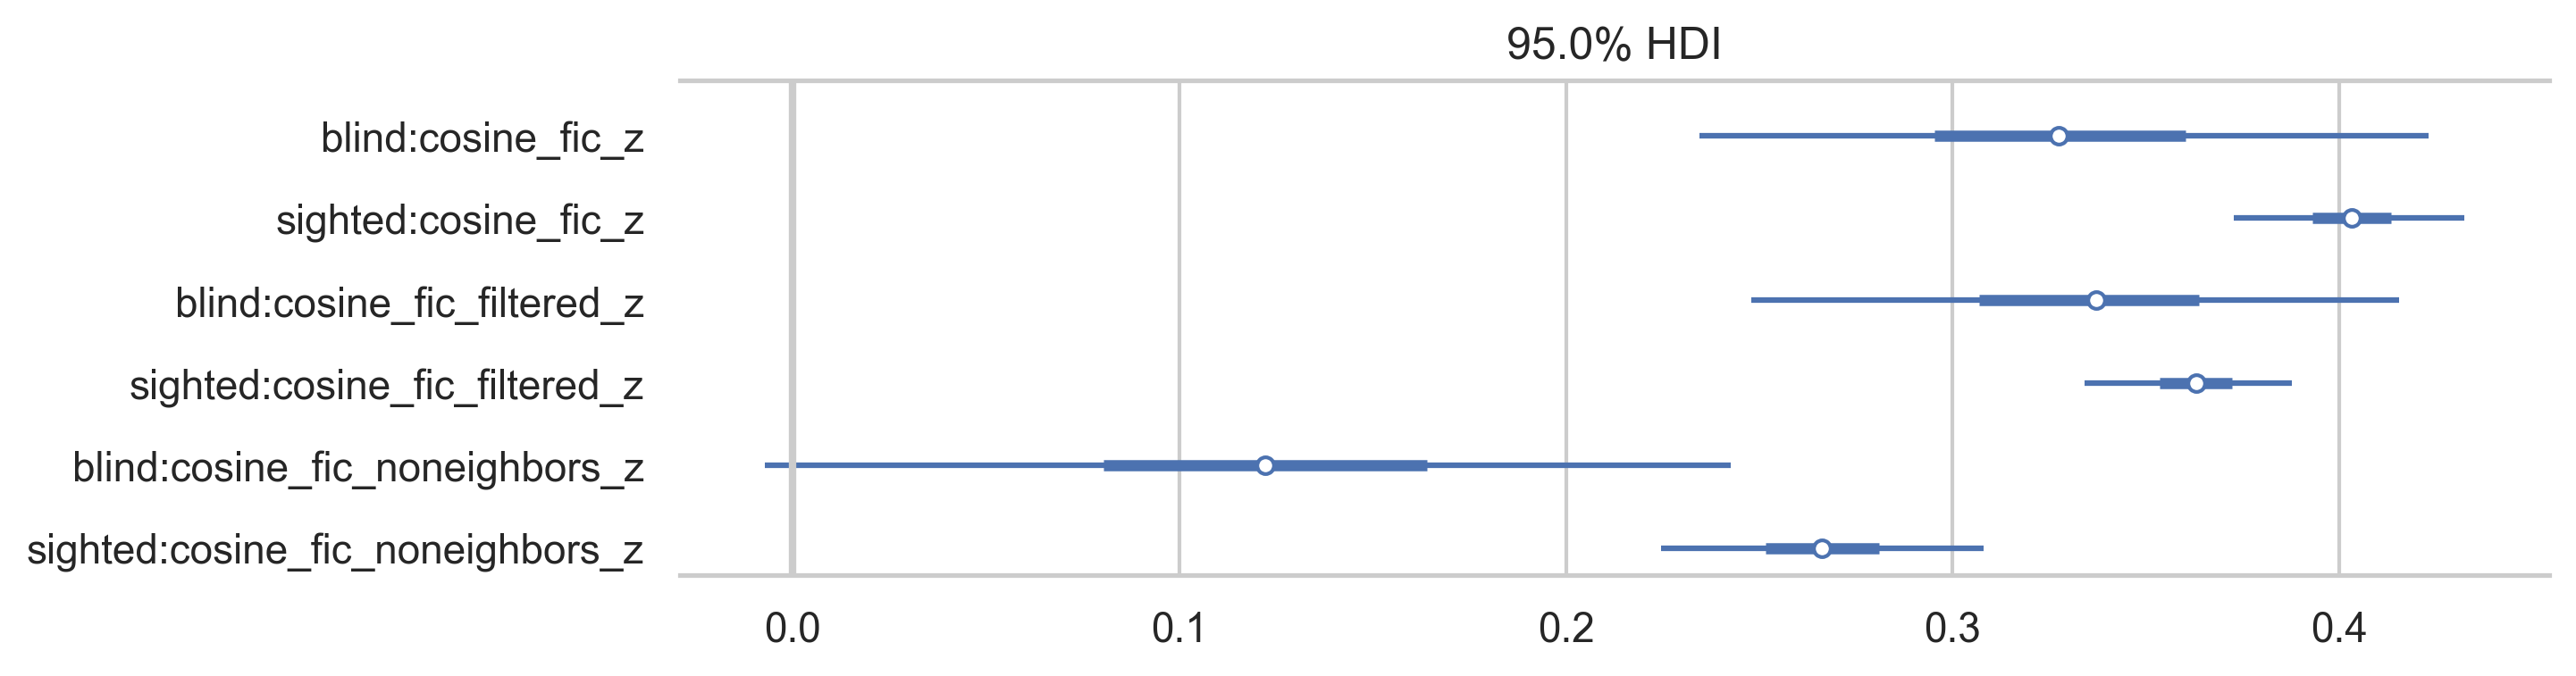

In [9]:
# compute and plot conditional effect of cosine in sighted and blind groups
from copy import deepcopy
trace_none = deepcopy(r_fic_noneighbors.posterior)
# effect of cosine in blind group in orginal experiment
trace['blind:cosine_fic_noneighbors_z'] = trace_none['cosine_fic_noneighbors_z'] - trace_none['group_eff:cosine_fic_noneighbors_z']
# effect of cosine in sighted group across both experiments
trace['sighted:cosine_fic_noneighbors_z'] = trace_none['cosine_fic_noneighbors_z'] + trace_none['group_eff:cosine_fic_noneighbors_z']

varnames = [
    'blind:cosine_fic_z', 'sighted:cosine_fic_z',
    'blind:cosine_fic_filtered_z', 'sighted:cosine_fic_filtered_z',
    'blind:cosine_fic_noneighbors_z', 'sighted:cosine_fic_noneighbors_z',
]
g = az.plot_forest(trace, combined=True, hdi_prob=.95,
                   figsize=[9, .6 + len(varnames) * .3],
                   var_names=varnames)
g[0].axvline(0, color='.8', linewidth=2);

## COCA-fiction without names provided by participants for color-semantic dimensions

In [4]:
m_fic_nonames = bambi.Model('rating_z ~ 1'
    + ' + group_eff*frequency_z'
    + ' + group_eff*concreteness_z'
    + ' + group_eff*cosine_fic_nonames_z'
    + ' + group_eff*swow_all_z'
    + ' + (1 + frequency_z + concreteness_z + cosine_fic_nonames_z + swow_all_z|pp_id)'
    + ' + (1 + group_eff|dimension)'
    + ' + (1 + group_eff|color)',
    df_joint[df_joint['self_vs_other'] == 'self']
)
r_fic_nonames = m_fic_nonames.fit(
    init='advi+adapt_diag',
    chains=4,
    draws=1000,
    tune=1000,
    n_init=10000,
    target_accept=.95,
)

Auto-assigning NUTS sampler...
[INFO] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
[INFO] Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 42,687
[INFO] Finished [100%]: Average Loss = 42,687
Multiprocess sampling (4 chains in 4 jobs)
[INFO] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, group_eff, frequency_z, group_eff:frequency_z, concreteness_z, group_eff:concreteness_z, cosine_fic_nonames_z, group_eff:cosine_fic_nonames_z, swow_all_z, group_eff:swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequency_z|pp_id_offset, concreteness_z|pp_id_sigma, concreteness_z|pp_id_offset, cosine_fic_nonames_z|pp_id_sigma, cosine_fic_nonames_z|pp_id_offset, swow_all_z|pp_id_sigma, swow_all_z|pp_id_offset, 1|dimension_sigma, 1|dimension_offset, group_eff|dimension_sigma, group_eff|dimension_offset, 1|color_sigma, 1|color_offset, group_eff|color_sigma, group_eff|color_offset, rating_z_sigma]
[INFO] NUTS: [Intercept, group_eff, frequency_z, group_eff:frequency_z, concreteness_z, group_eff:concreteness_z, cosine_fic_nonames_z, group_eff:cosine_fic_nonames_z, swow_all_z, gr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1371 seconds.
[INFO] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1371 seconds.


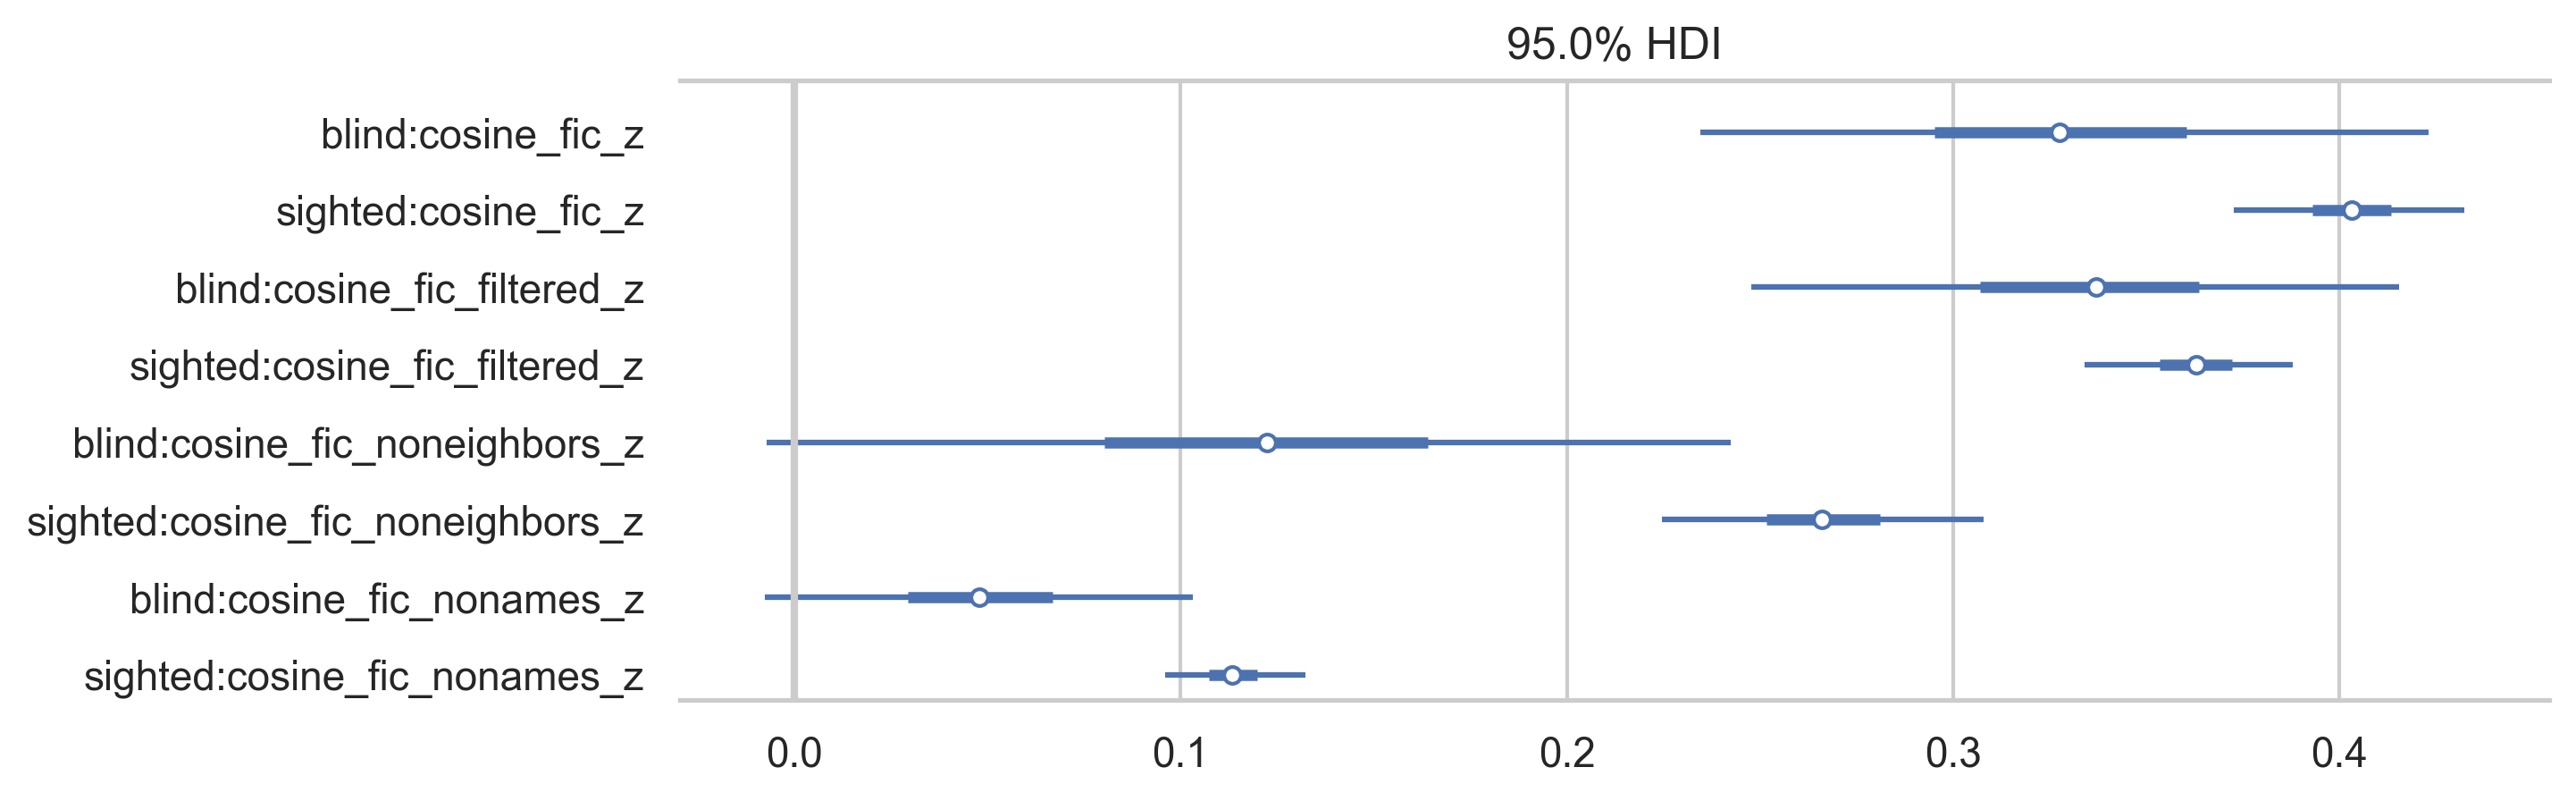

In [11]:
# compute and plot conditional effect of cosine in sighted and blind groups
trace_none = deepcopy(r_fic_nonames.posterior)
# effect of cosine in blind group in orginal experiment
trace['blind:cosine_fic_nonames_z'] = trace_none['cosine_fic_nonames_z'] - trace_none['group_eff:cosine_fic_nonames_z']
# effect of cosine in sighted group across both experiments
trace['sighted:cosine_fic_nonames_z'] = trace_none['cosine_fic_nonames_z'] + trace_none['group_eff:cosine_fic_nonames_z']

varnames = [
    'blind:cosine_fic_z', 'sighted:cosine_fic_z',
    'blind:cosine_fic_filtered_z', 'sighted:cosine_fic_filtered_z',
    'blind:cosine_fic_noneighbors_z', 'sighted:cosine_fic_noneighbors_z',
    'blind:cosine_fic_nonames_z', 'sighted:cosine_fic_nonames_z',
]
g = az.plot_forest(trace, combined=True, hdi_prob=.95,
                   figsize=[9, .6 + len(varnames) * .3],
                   var_names=varnames)
g[0].axvline(0, color='.8', linewidth=2);

/opt/homebrew/lib/python3.9/site-packages/seaborn/categorical.py:1727: UserWarning: You passed a edgecolor/edgecolors ((0.00392156862745098, 0.45098039215686275, 0.6980392156862745)) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/opt/homebrew/lib/python3.9/site-packages/seaborn/categorical.py:1727: UserWarning: You passed a edgecolor/edgecolors ((0.8705882352941177, 0.5607843137254902, 0.0196078431372549)) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


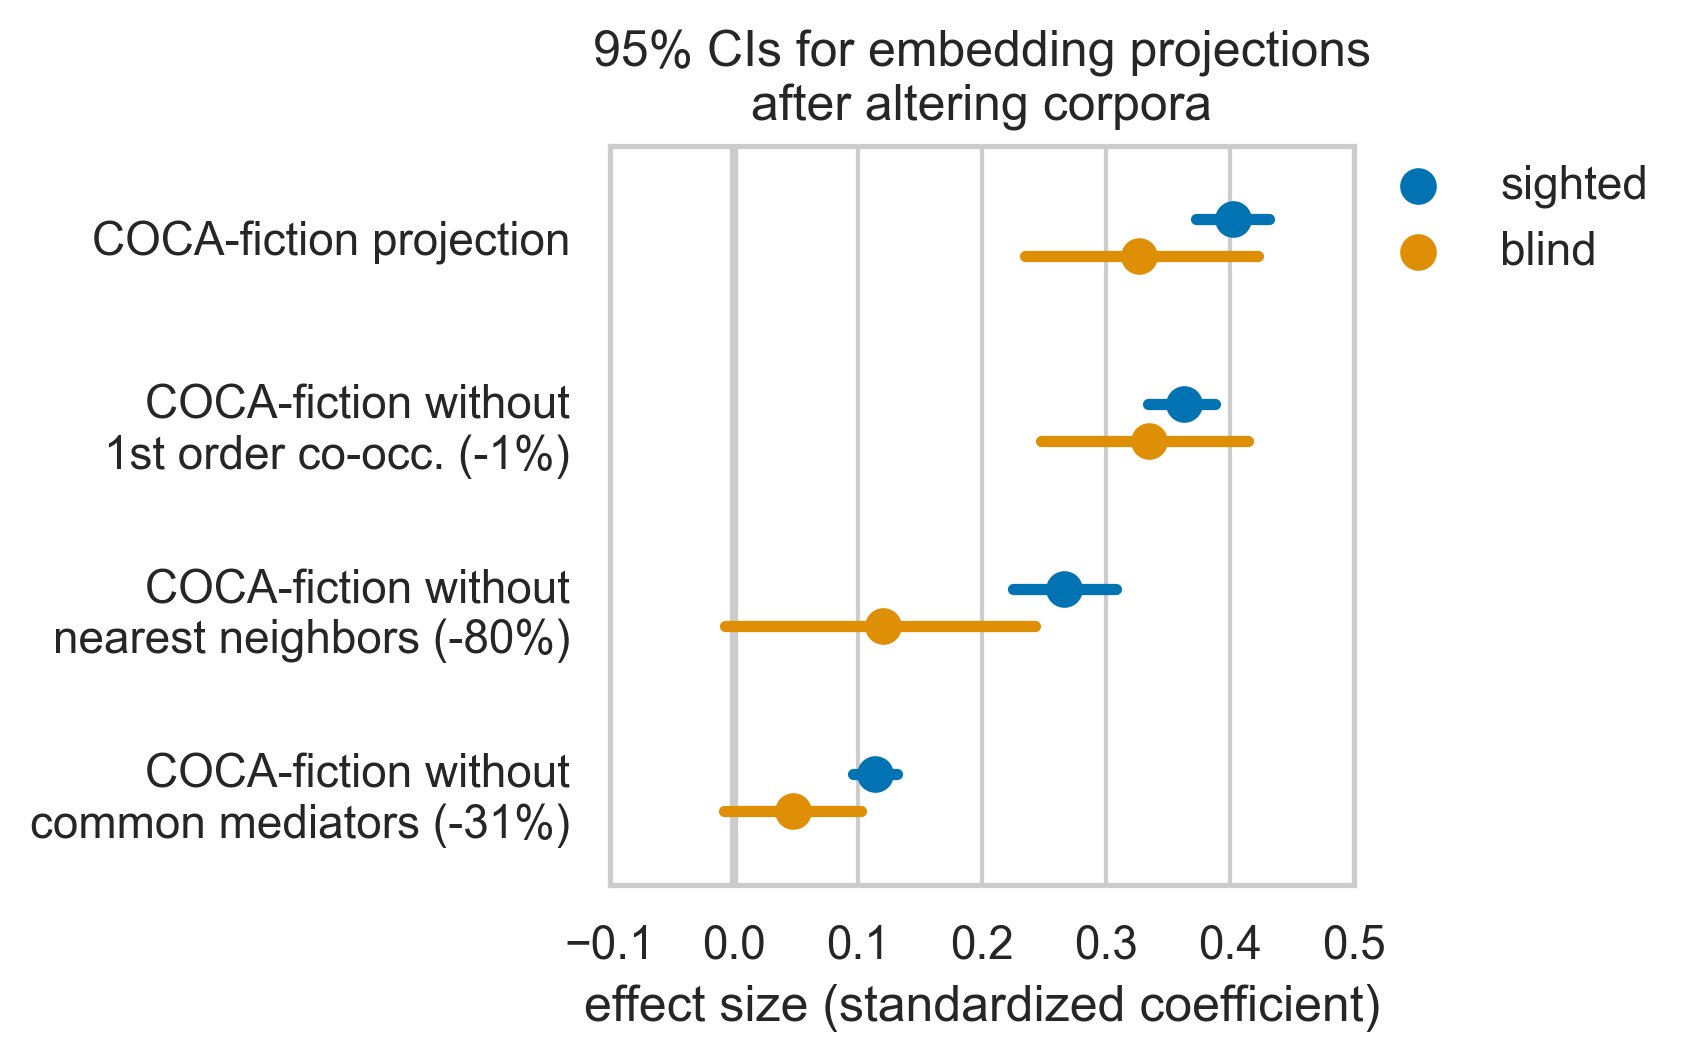

In [12]:
varnames = [
    'sighted:cosine_fic_z',
    'sighted:cosine_fic_filtered_z',
    'sighted:cosine_fic_noneighbors_z',
    'sighted:cosine_fic_nonames_z',
    'blind:cosine_fic_z',
    'blind:cosine_fic_filtered_z',
    'blind:cosine_fic_noneighbors_z',
    'blind:cosine_fic_nonames_z',
]
trace_df = az.summary(trace, hdi_prob=.95, var_names=varnames).reset_index()
sns.set(palette='colorblind', style='whitegrid')
trace_df['group'] = trace_df['index'].apply(lambda x: x.split(':')[0])
trace_df['predictor'] = trace_df['index'].apply(lambda x: x.split(':')[1])
g, ax = plt.subplots(figsize=[3.2, 3.2])
ax.axvline(0, color='.8', linewidth=2)
order = [
    'sighted:cosine_fic_z',
    'sighted:cosine_fic_filtered_z',
    'sighted:cosine_fic_noneighbors_z',
    'sighted:cosine_fic_nonames_z',
    'blind:cosine_fic_z',
    'blind:cosine_fic_filtered_z',
    'blind:cosine_fic_noneighbors_z',
    'blind:cosine_fic_nonames_z',
]
order = [
    'cosine_fic_z',
    'cosine_fic_filtered_z',
    'cosine_fic_noneighbors_z',
    'cosine_fic_nonames_z',
]
sns.pointplot(data=trace_df, hue='group', x='mean', y='predictor', join=False, ax=ax, order=order,
              palette=sns.color_palette()[0:], dodge=.2)
hdi_df = trace_df.melt(id_vars=['predictor', 'group'], value_vars=['hdi_2.5%', 'hdi_97.5%'])
sns.pointplot(data=hdi_df, hue='group', markers='', x='value', order=order,
              y='predictor', ax=ax, join=False,
              palette=sns.color_palette()[0:], dodge=.2)
ax.set(xlim=[-.1, .5], xticks=[-.1, 0, .1, .2, .3, .4, .5],
       ylabel='', xlabel='effect size (standardized coefficient)',
       title='95% CIs for embedding projections\nafter altering corpora')
ax.set(yticklabels=[
    'COCA-fiction projection',
    'COCA-fiction without\n1st order co-occ. (-1%)',
    'COCA-fiction without\nnearest neighbors (-80%)',
    'COCA-fiction without\ncommon mediators (-31%)',
])
labels = ax.get_legend_handles_labels()
ax.legend(handles=labels[0][:2], labels=labels[1][:2],
          bbox_to_anchor=(1, 1), loc=2, borderaxespad=0, frameon=False)
plt.savefig('figures/corpus_modification_forest.pdf', bbox_inches='tight')

In [13]:
display(az.summary(trace, hdi_prob=.95, var_names=varnames))

mean     sd  hdi_2.5%  hdi_97.5%  \
sighted:cosine_fic_z              0.403  0.015     0.373      0.432   
sighted:cosine_fic_filtered_z     0.363  0.014     0.334      0.388   
sighted:cosine_fic_noneighbors_z  0.266  0.022     0.225      0.308   
sighted:cosine_fic_nonames_z      0.114  0.009     0.096      0.132   
blind:cosine_fic_z                0.327  0.048     0.235      0.423   
blind:cosine_fic_filtered_z       0.335  0.043     0.248      0.415   
blind:cosine_fic_noneighbors_z    0.120  0.063    -0.007      0.243   
blind:cosine_fic_nonames_z        0.048  0.028    -0.008      0.103   

                                  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sighted:cosine_fic_z                  0.000    0.000    4598.0    3618.0   
sighted:cosine_fic_filtered_z         0.000    0.000    4433.0    3470.0   
sighted:cosine_fic_noneighbors_z      0.000    0.000    3836.0    3019.0   
sighted:cosine_fic_nonames_z          0.000    0.000    5393.0    3159.0   
blind:cosine_fic_z                    0.001    0.001    3927.0    3058.0   
blind:cosine_fic_filtered_z           0.001    0.001    2655.0    2458.0   
blind:cosine_fic_noneighbors_z        0.001    0.001    2130.0    2342.0   
blind:cosine_fic_nonames_z            0.001    0.000    2888.0    2421.0   

                                  r_hat  
sighted:cosine_fic_z                1.0  
sighted:cosine_fic_filtered_z       1.0  
sighted:cosine_fic_noneighbors_z    1.0  
sighted:cosine_fic_nonames_z        1.0  
blind:cosine_fic_z                  1.0  
blind:cosine_fic_filtered_z         1.0  
blind:cosine_fic_noneighbors_z      1.0  
blind:cosine_fic_nonames_z          1.0

## Comparing models on leave-one-out validation score
Instead of using conditional effect sizes from the models as a comparison, we can also compare the models on their out-of-sample predictive accuracy. Essentially we're looking to see which predictor, if included, makes the model _worst_.  
Using prediction/cross-validation for model comparison has distinct advantages in some situations, but in our case (when we're not varying model complexity or structure, but only replacing a single predictor) the results will probably match our inferences from the conditional effect size plots.

In [14]:
display(az.compare({
    'intact COCA fiction': r_fic,
    '1st order removed': r_fic_filtered,
    'semantic neighbors removed': r_fic_noneighbors,
    'salient labels removed': r_fic_nonames,
}).round(2))

/opt/homebrew/lib/python3.9/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/arviz/stats/stats.py:802: UserWarning: Est

rank  elpd_loo   p_loo  elpd_diff  weight      se  \
1st order removed              0 -32762.21  390.88       0.00    0.65  105.56   
intact COCA fiction            1 -32828.40  378.64      66.19    0.35  104.59   
semantic neighbors removed     2 -33184.29  328.22     422.08    0.00  103.81   
salient labels removed         3 -33191.91  333.56     429.70    0.00  103.41   

                              dse  warning scale  
1st order removed            0.00     True   log  
intact COCA fiction         21.01     True   log  
semantic neighbors removed  28.77     True   log  
salient labels removed      30.06     True   log

As expected, the no-mediator-words model fared worst, whereas filtering only first-order co-occurrences made exactly no difference with the unfiltered corpus whatsoever. (In fact, the first-order filtered model looks slightly better here, but judging by the assigned model weights it's pretty much a toss-up.)  
Removing semantic neighbors and removing salient names/labels seems to be fairly equivalent here, as well. Since removing salient labels was a much more targeted intervention (much smaller percentage of the corpus removed), that seems to have been the intervention that was most effective at identifying meaningful training samples.

The comparison algorithm does warn that the shape parameter of the pareto distribution is too large for some observations. This is common with hierarchical models and shouldn't be a problem if it concerns only a few observations. We can check this by inspecting the LOO-statistics more closely.

In [15]:
az.loo(r_fic_nonames)

/opt/homebrew/lib/python3.9/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 23938 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -33191.91   103.41
p_loo      333.56        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     23894   99.8%
 (0.5, 0.7]   (ok)          39    0.2%
   (0.7, 1]   (bad)          5    0.0%
   (1, Inf)   (very bad)     0    0.0%

It appears that for the no labels model, for instance, there are only a few observations in the "bad" range. This is not overly problematic given the nearly 24,000 observations that are in the correct range.

## Visual model diagnostics
R-hat and other Markov chain diagnostics looked good, but it's still worth doing a few quick visual model checks.
### Quick look at the trace plots
We want all the Markov chains for a single variable to look lined up in the density plot on the left, but nice and fuzzy (i.e. not autocorrelated) on the right.

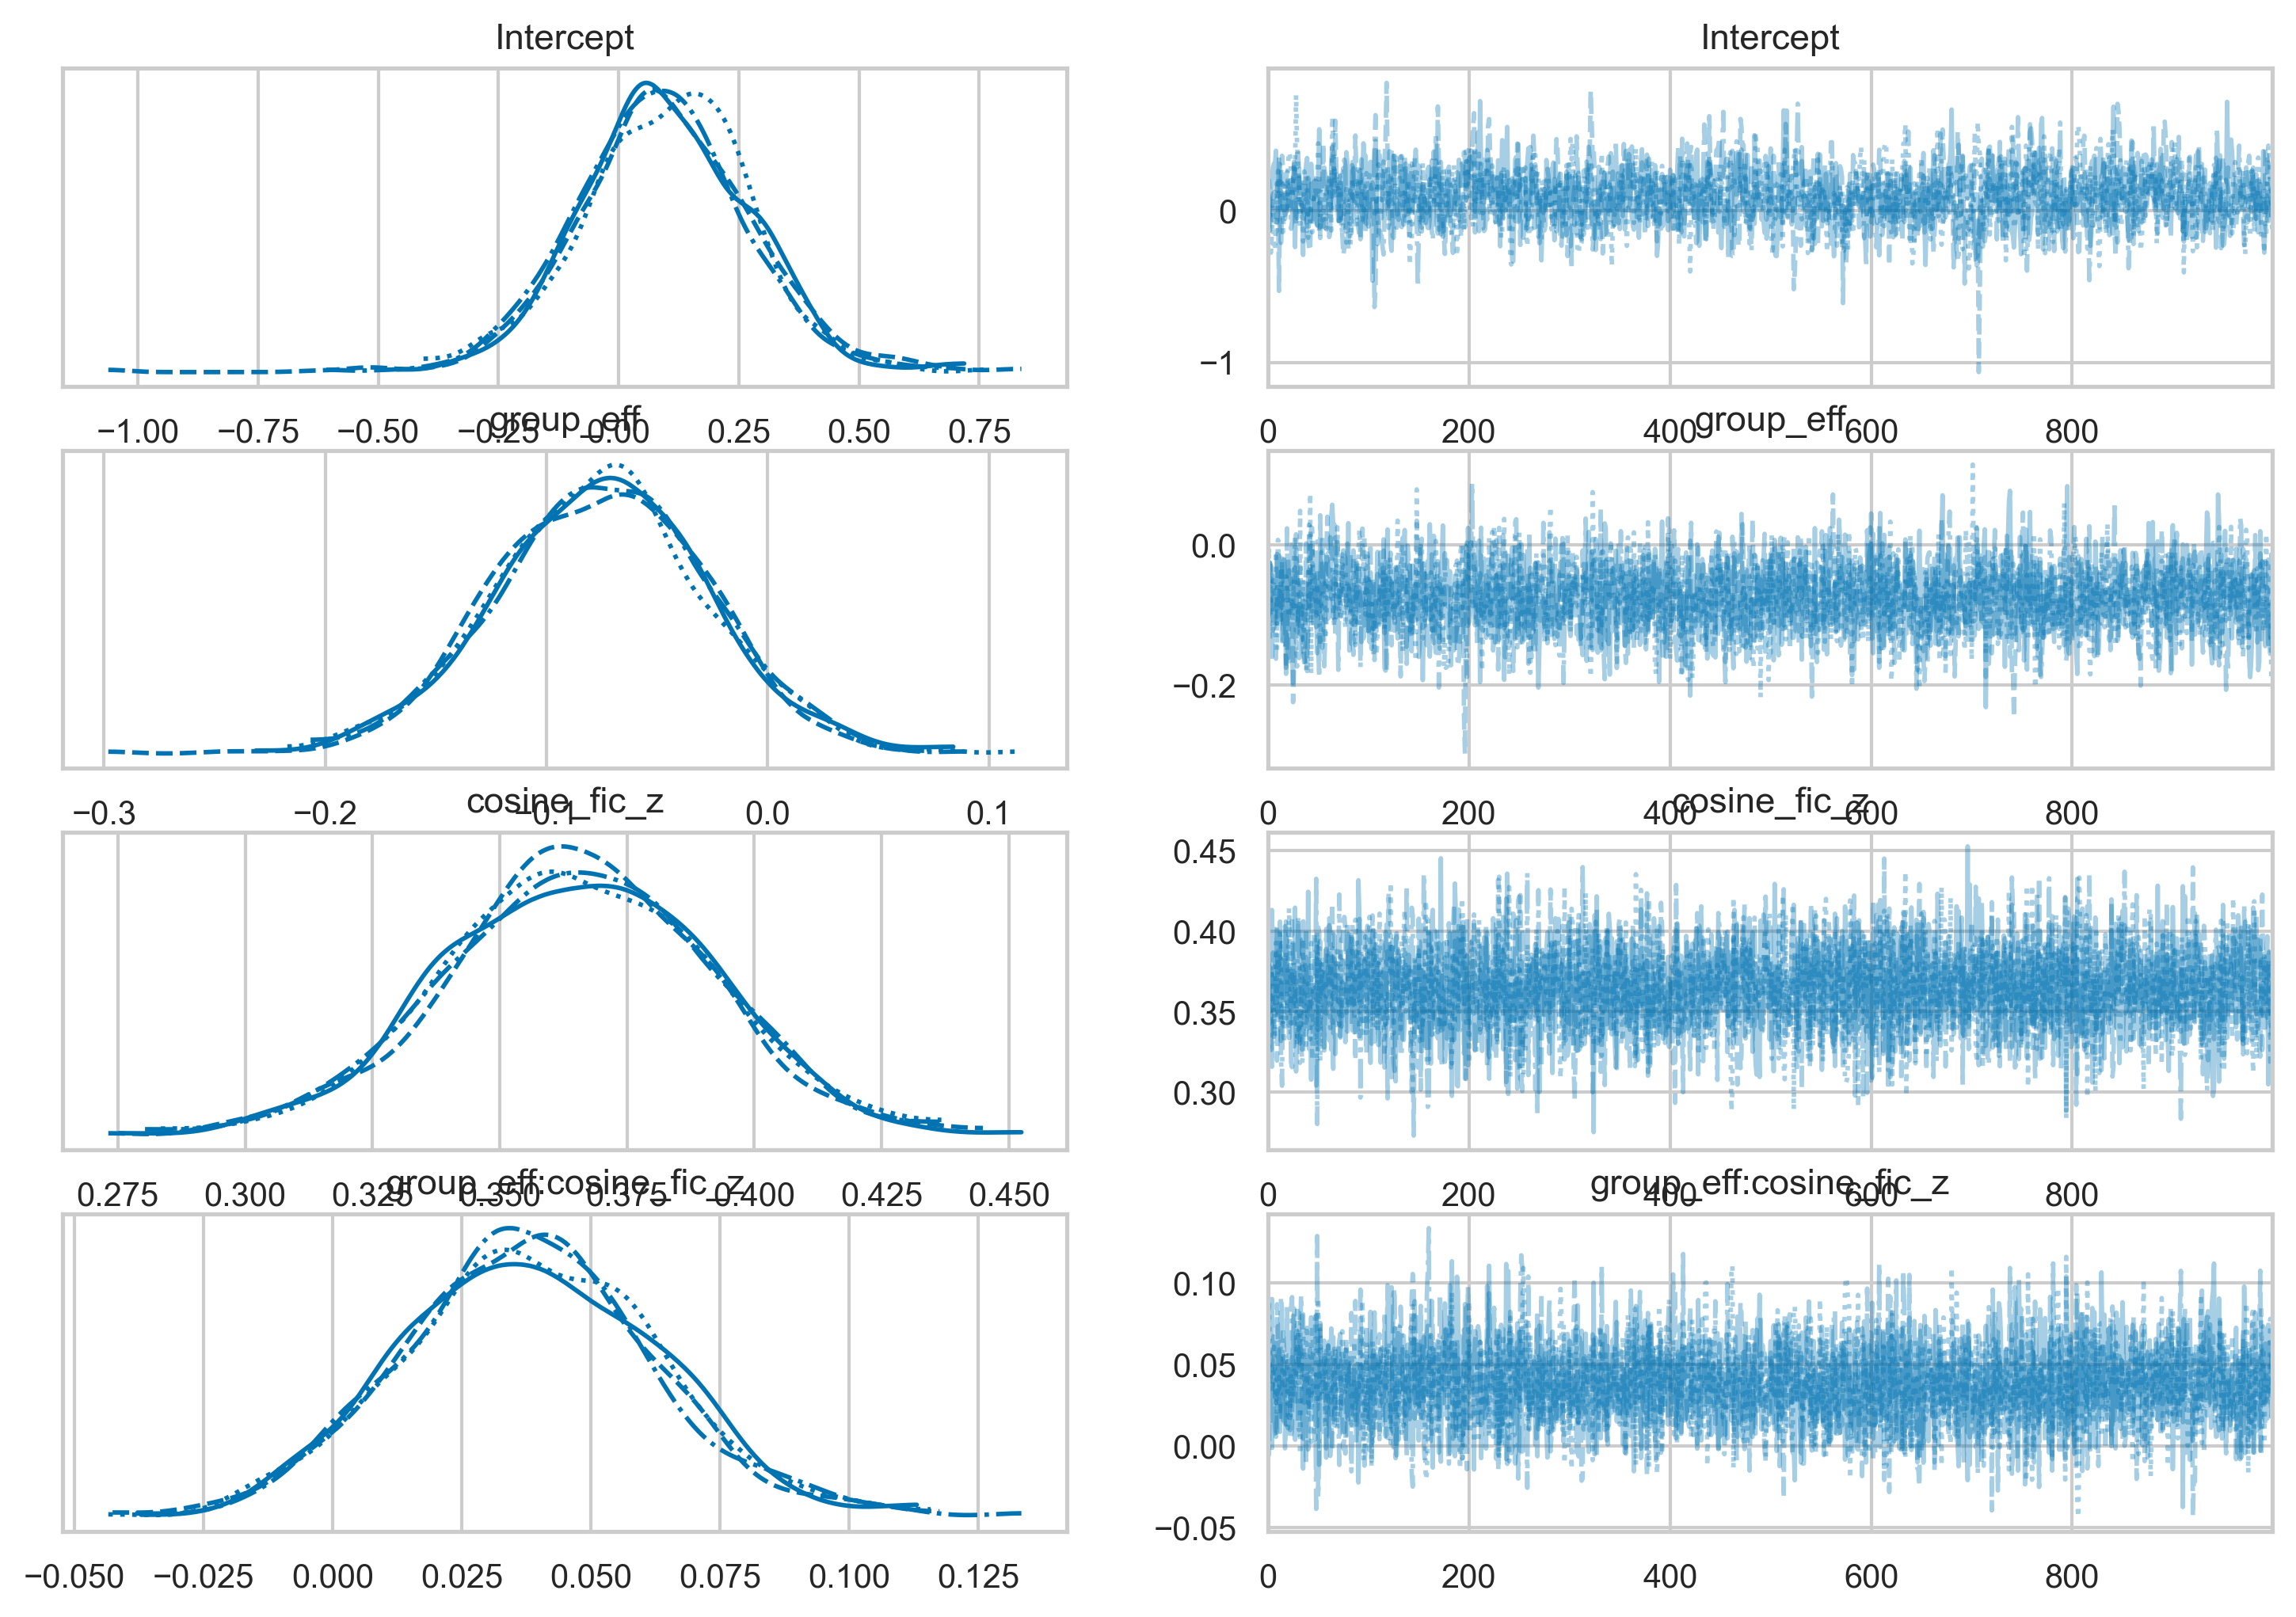

In [16]:
g = az.plot_trace(r_fic, var_names=['Intercept', 'group_eff', 'cosine_fic_z', 'group_eff:cosine_fic_z'])

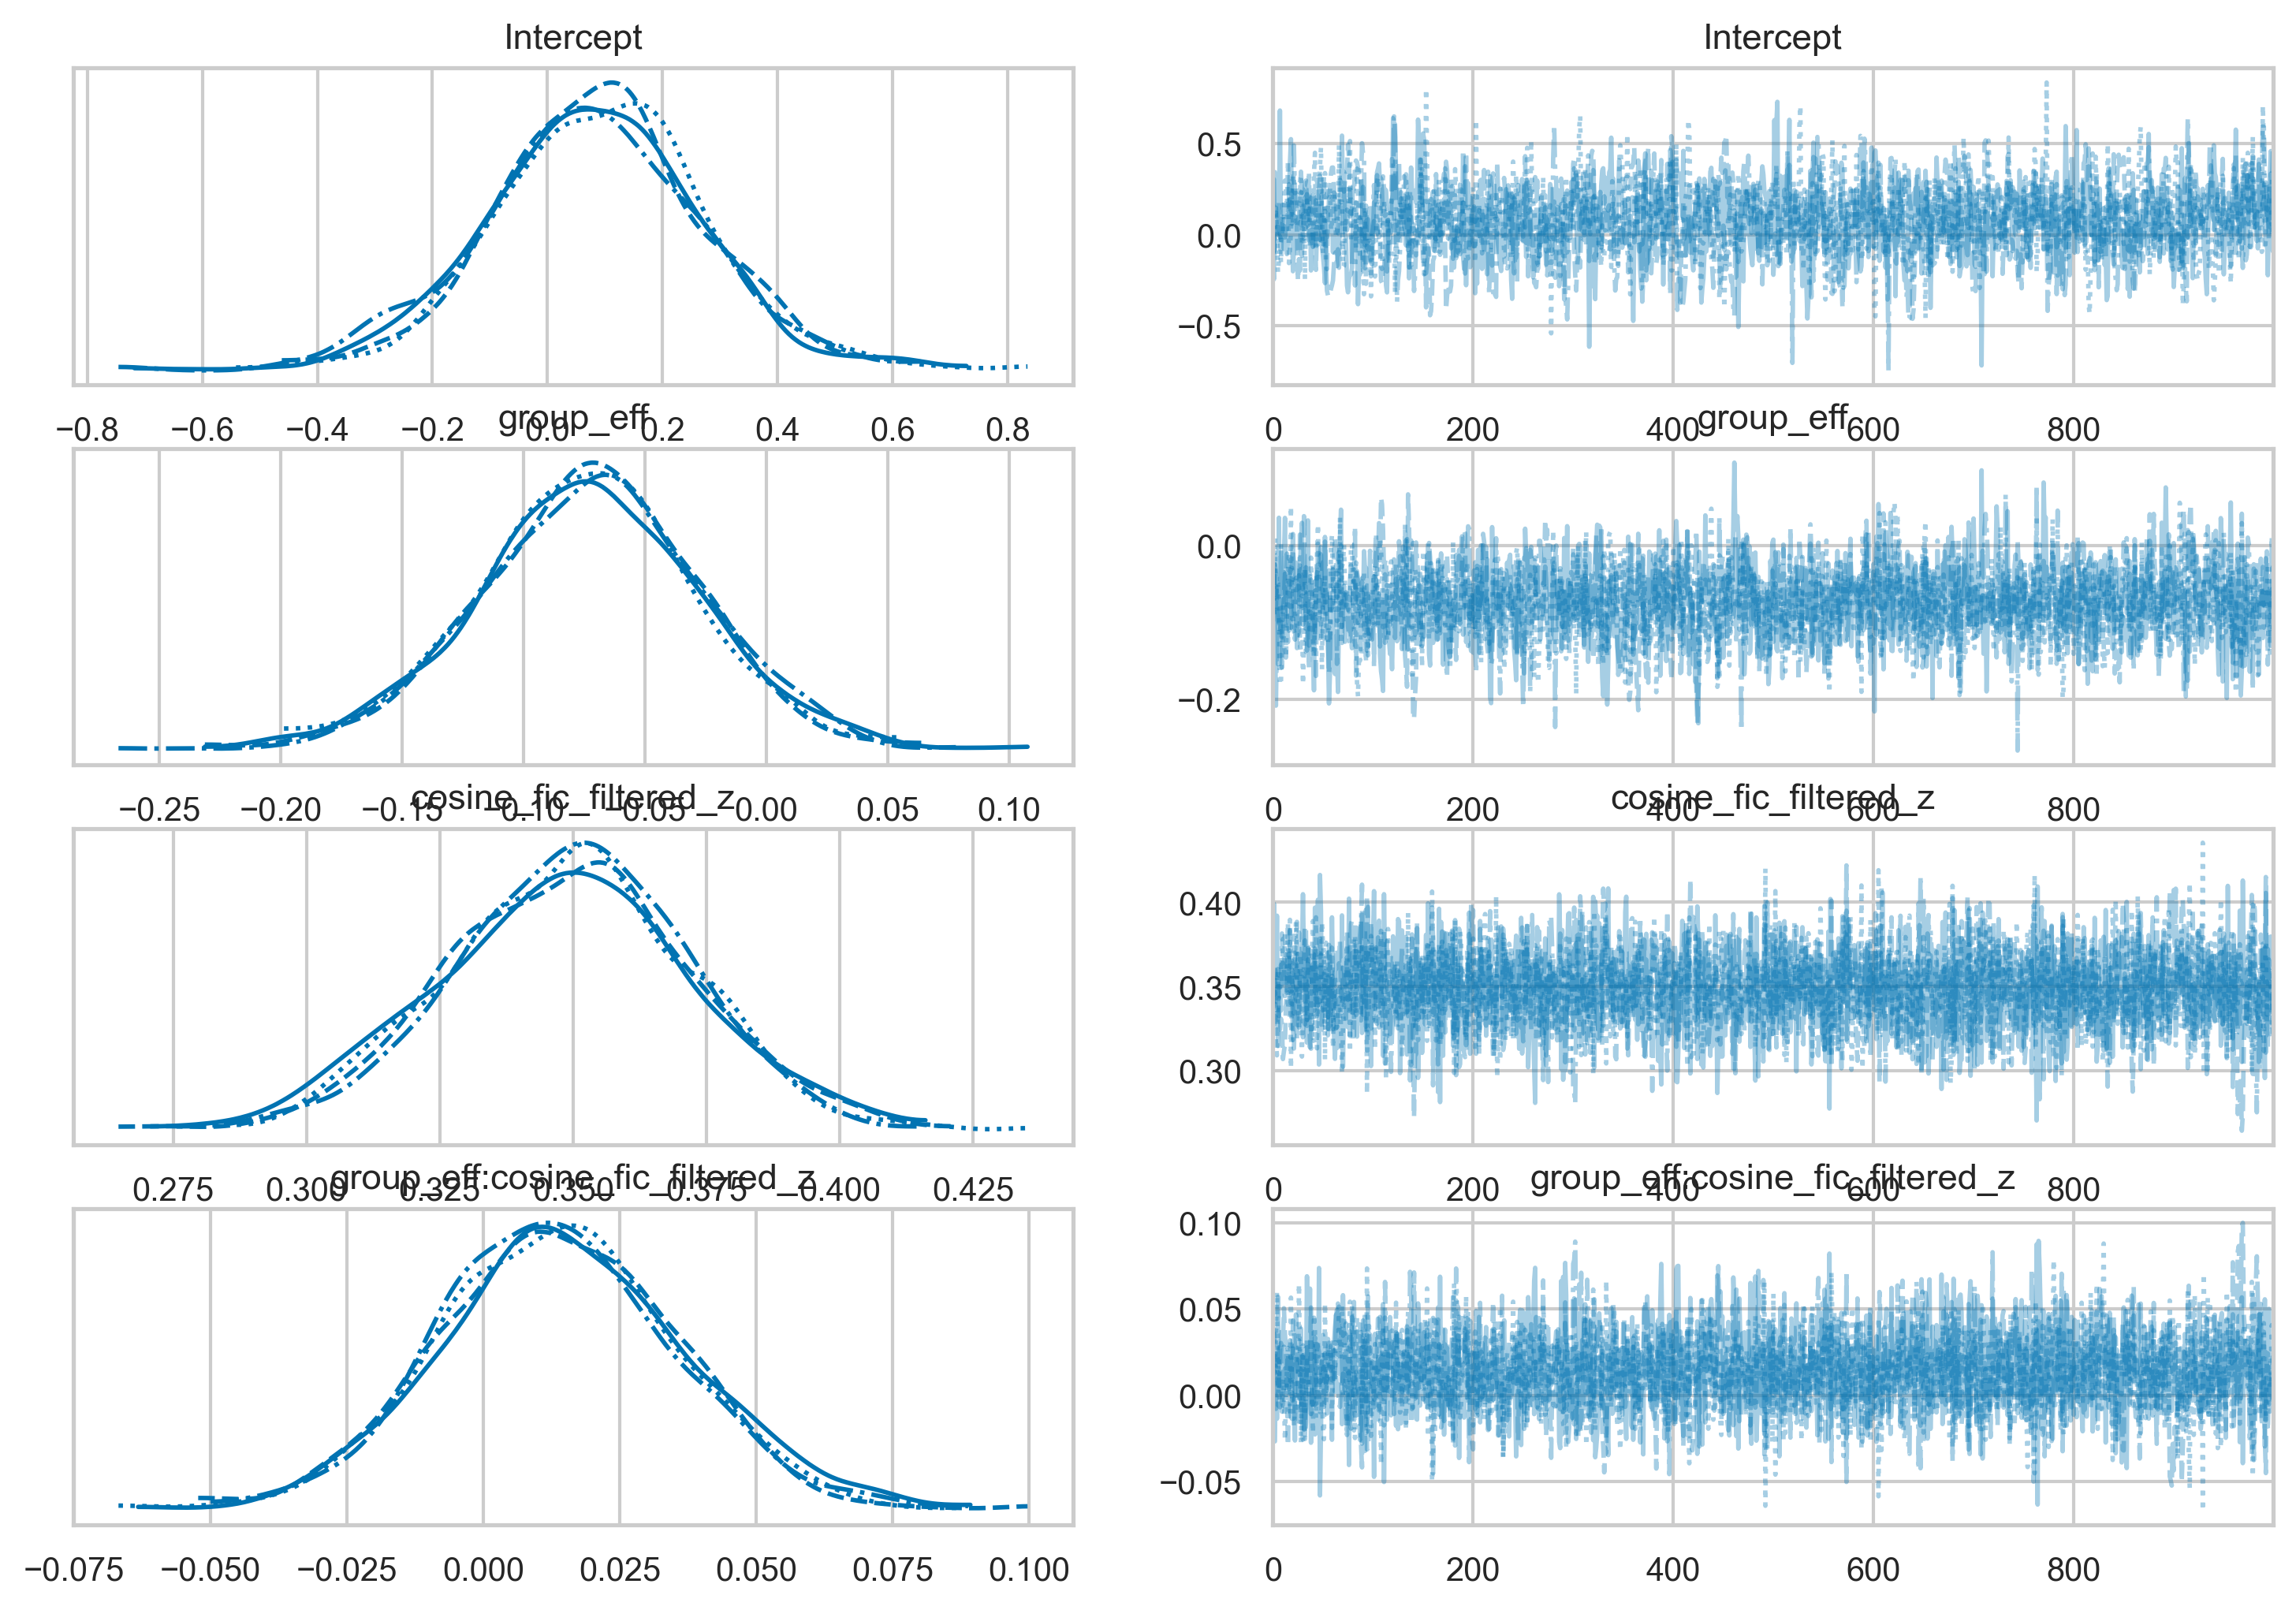

In [17]:
g = az.plot_trace(r_fic_filtered, var_names=['Intercept', 'group_eff', 'cosine_fic_filtered_z',
                                             'group_eff:cosine_fic_filtered_z'])

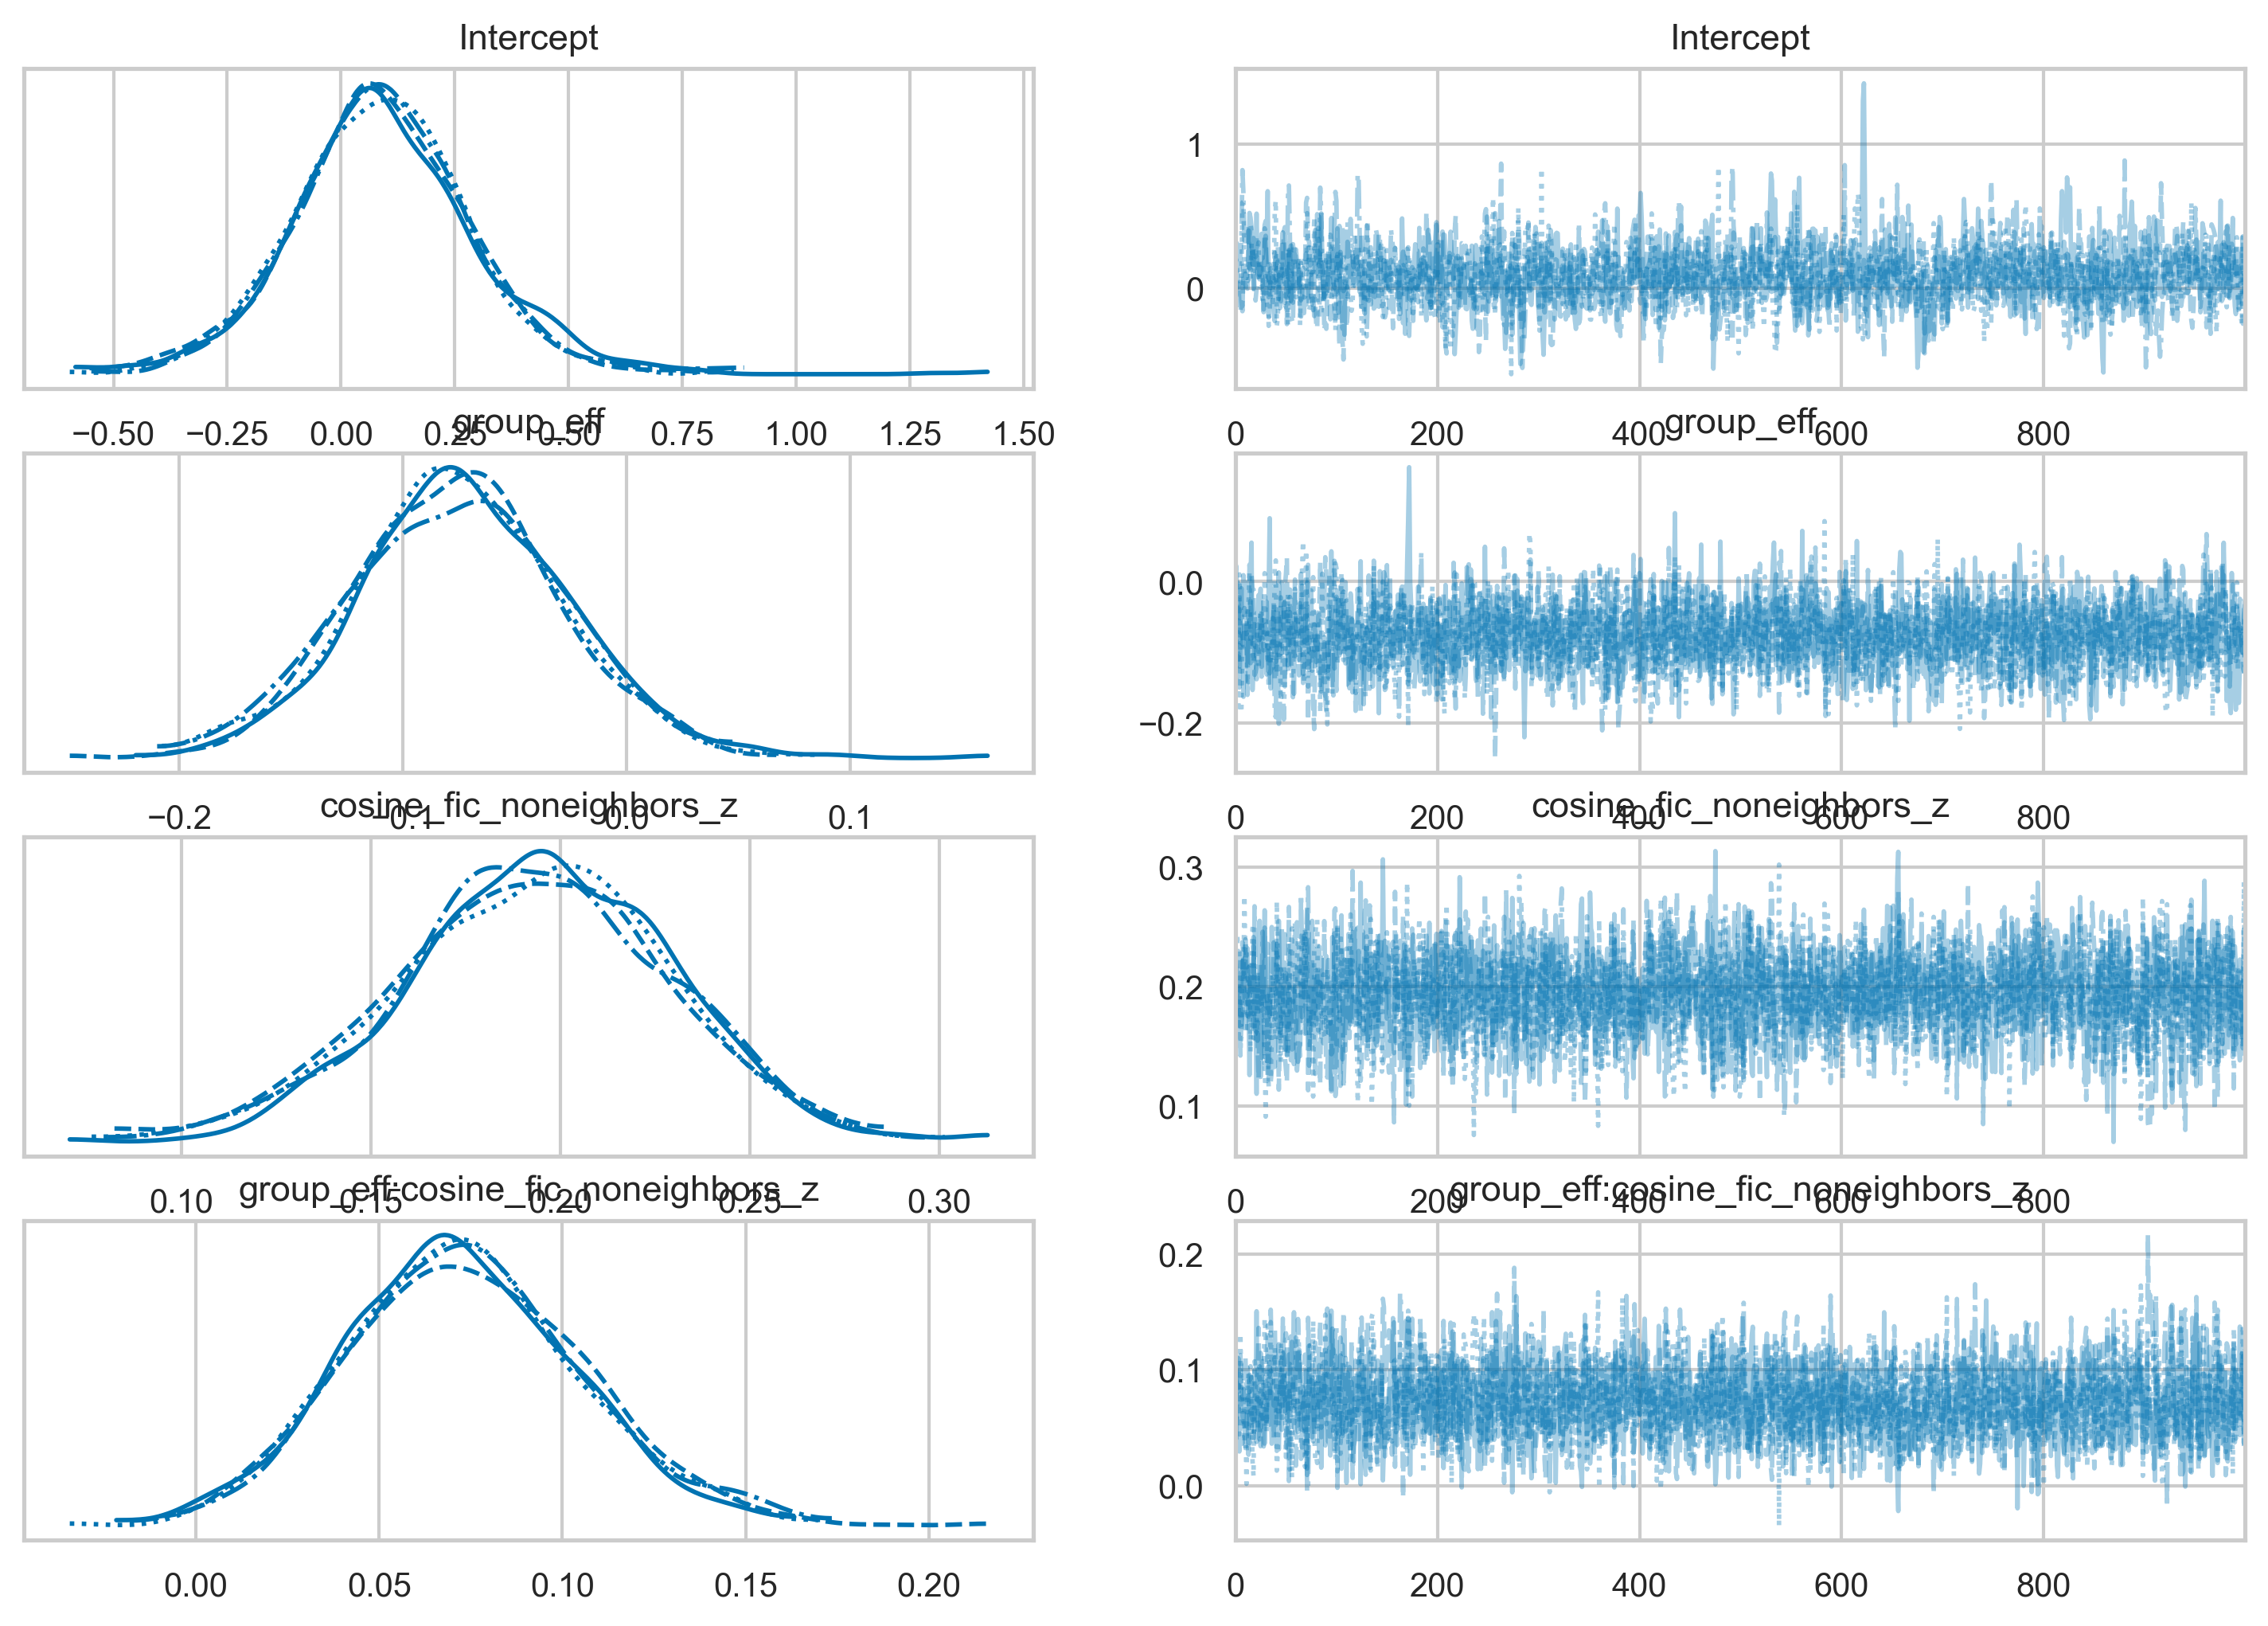

In [18]:
g = az.plot_trace(r_fic_noneighbors, var_names=['Intercept', 'group_eff', 'cosine_fic_noneighbors_z',
                                                'group_eff:cosine_fic_noneighbors_z'])

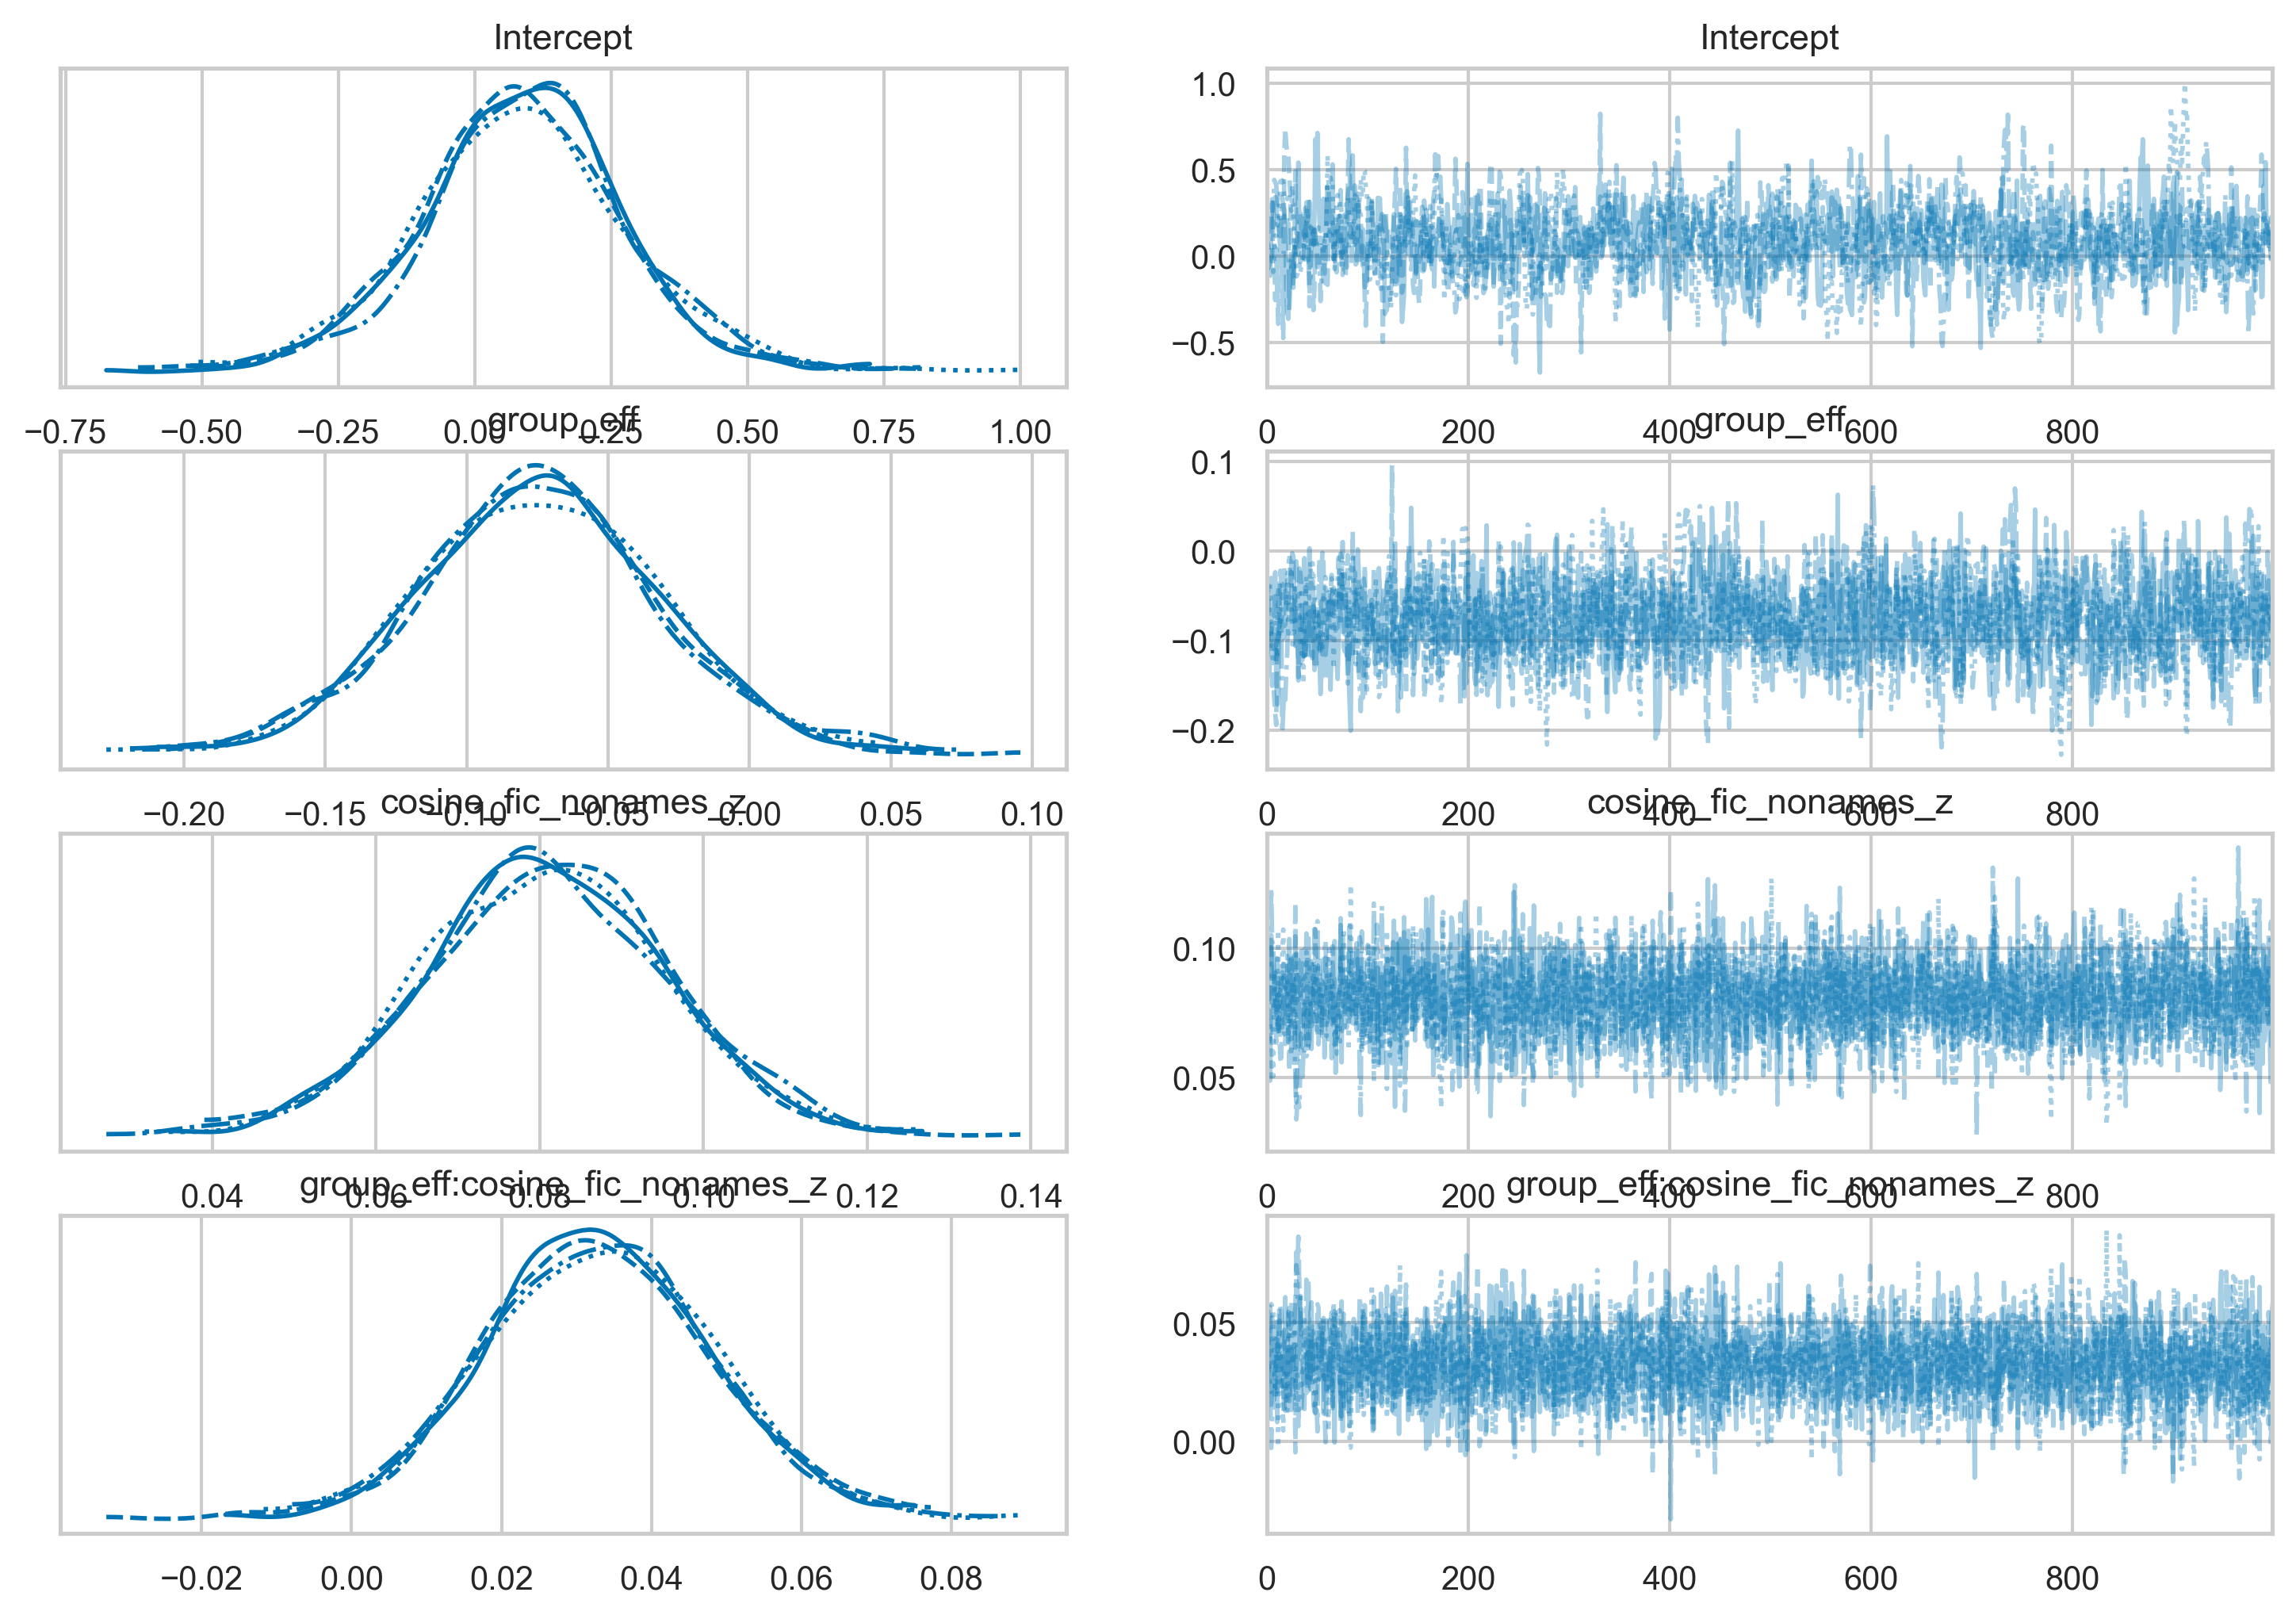

In [19]:
g = az.plot_trace(r_fic_nonames, var_names=['Intercept', 'group_eff', 'cosine_fic_nonames_z',
                                            'group_eff:cosine_fic_nonames_z'])

### Cumulative posterior predictive check
Check if the model's predictions line up with the predictions in our observed data (i.e. there are no weird biases etc.)

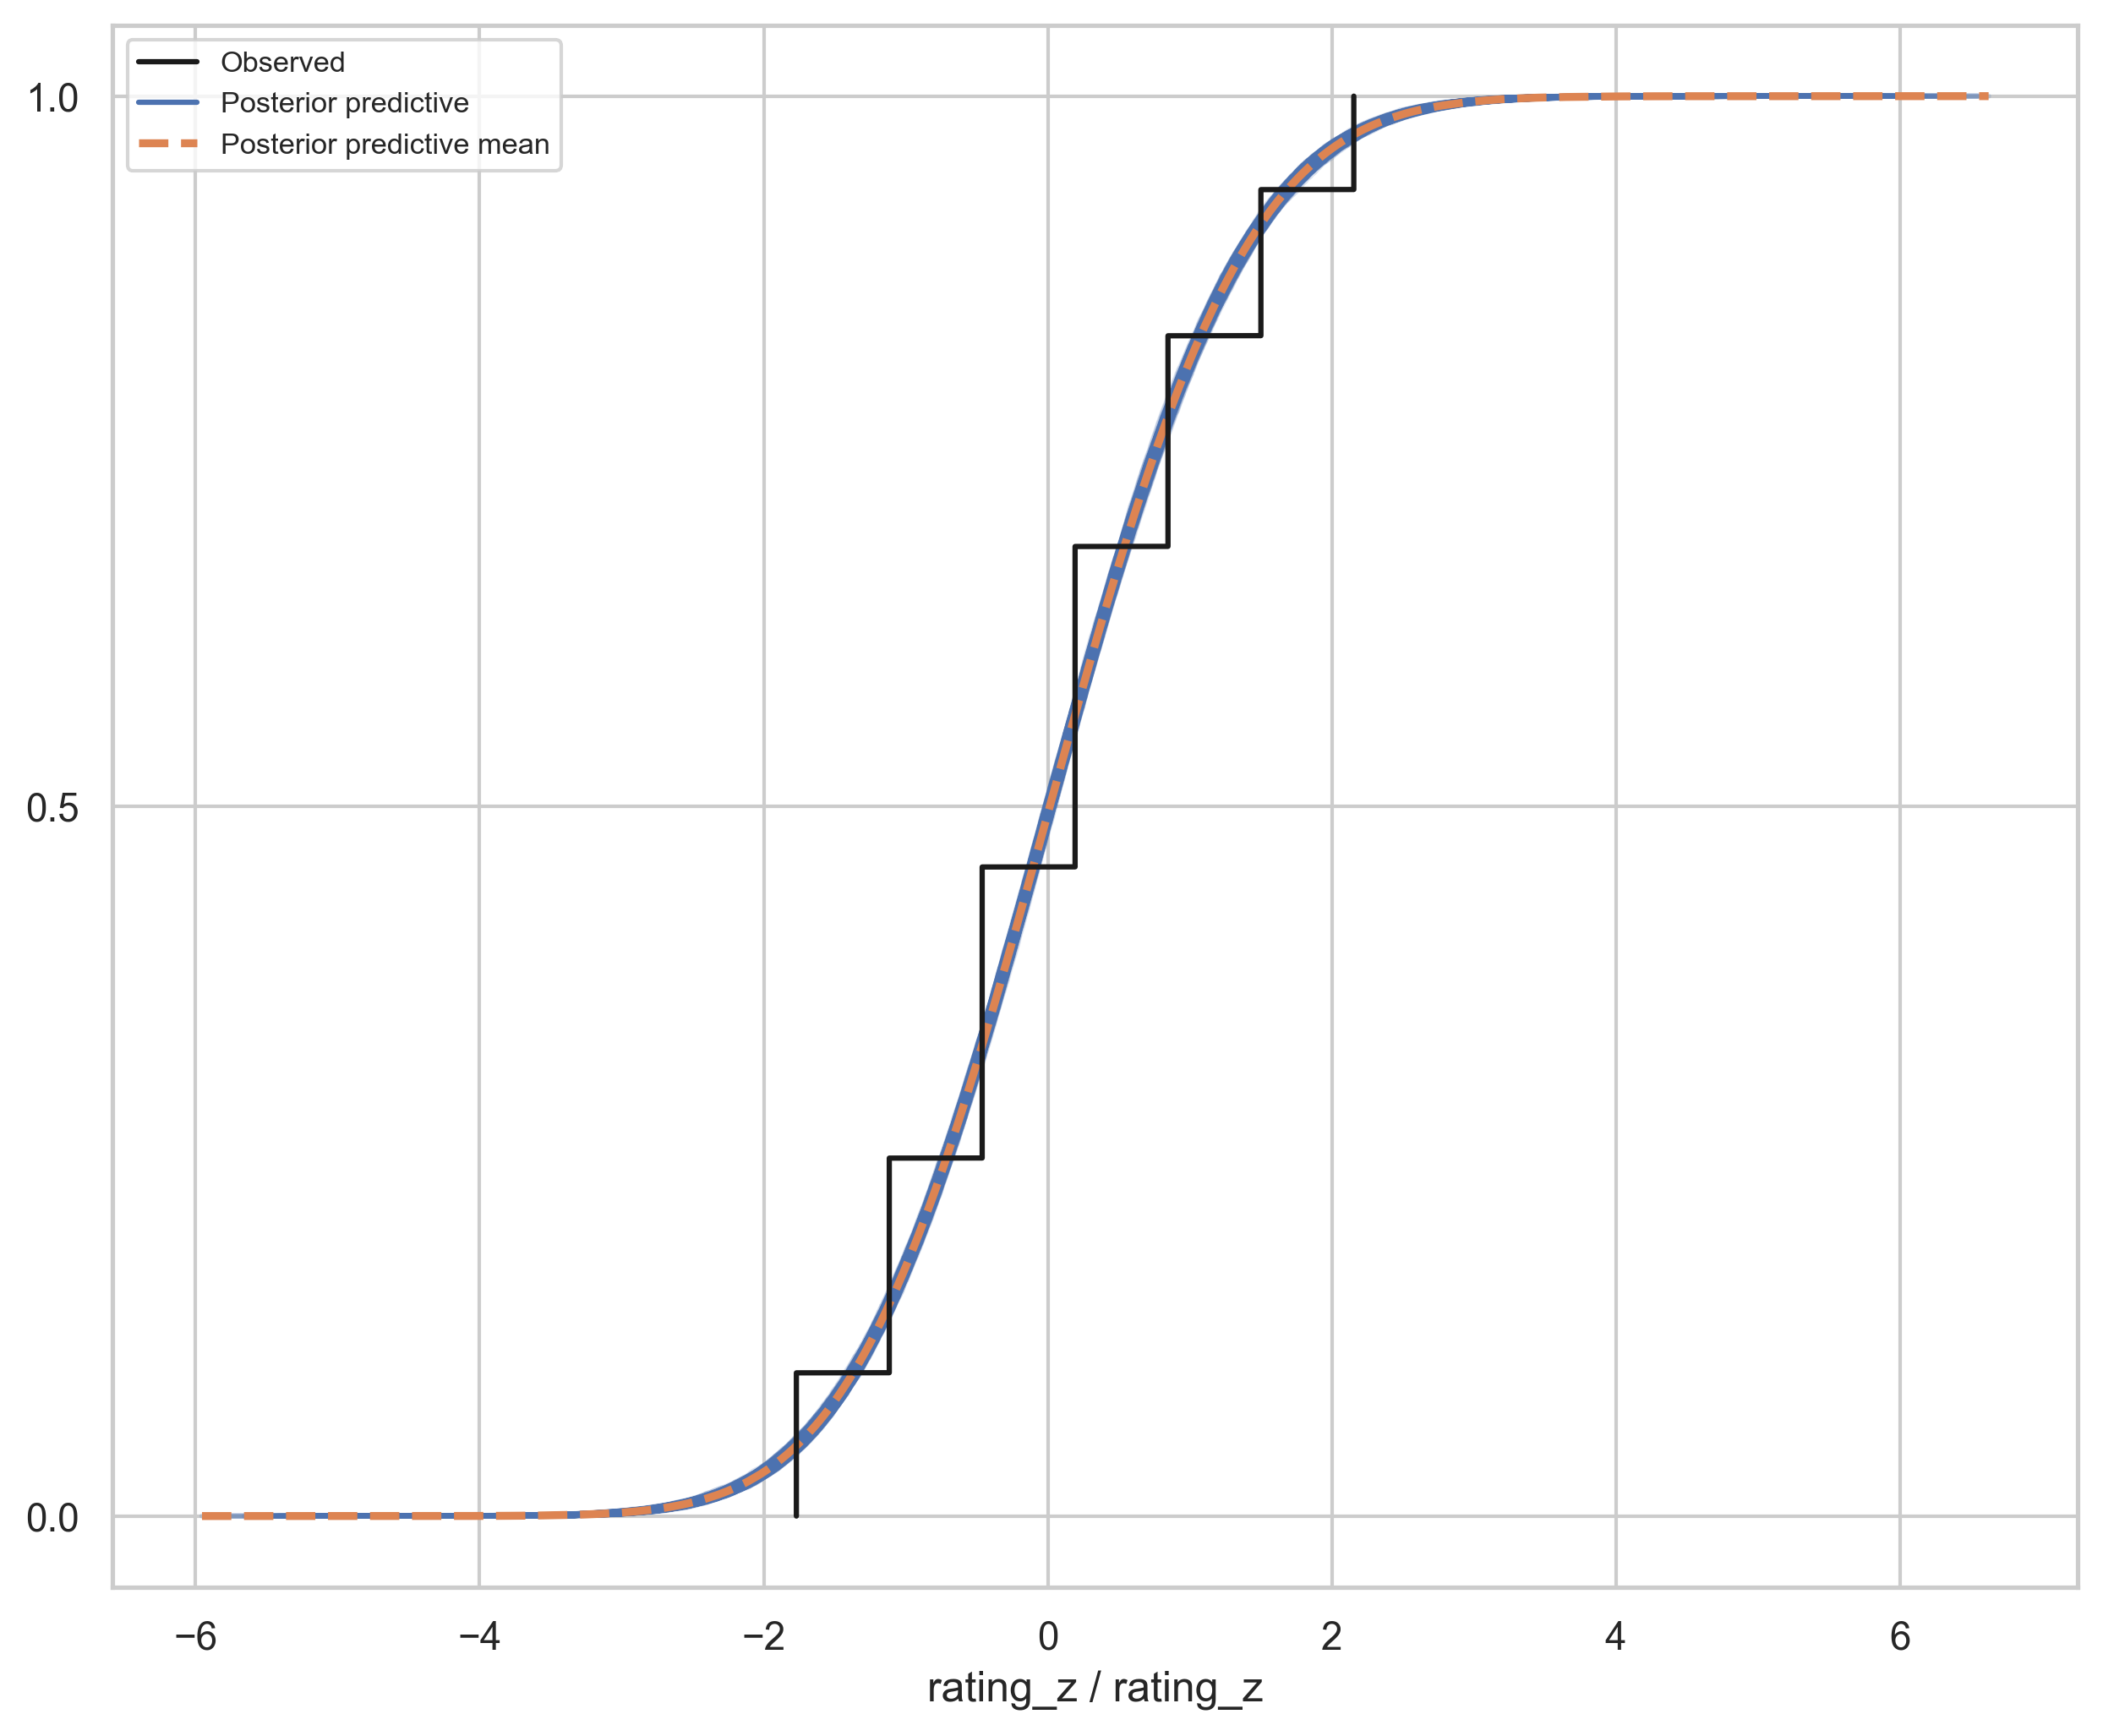

In [6]:
m_fic.predict(r_fic, kind='pps')
g = az.plot_ppc(r_fic, kind='cumulative')

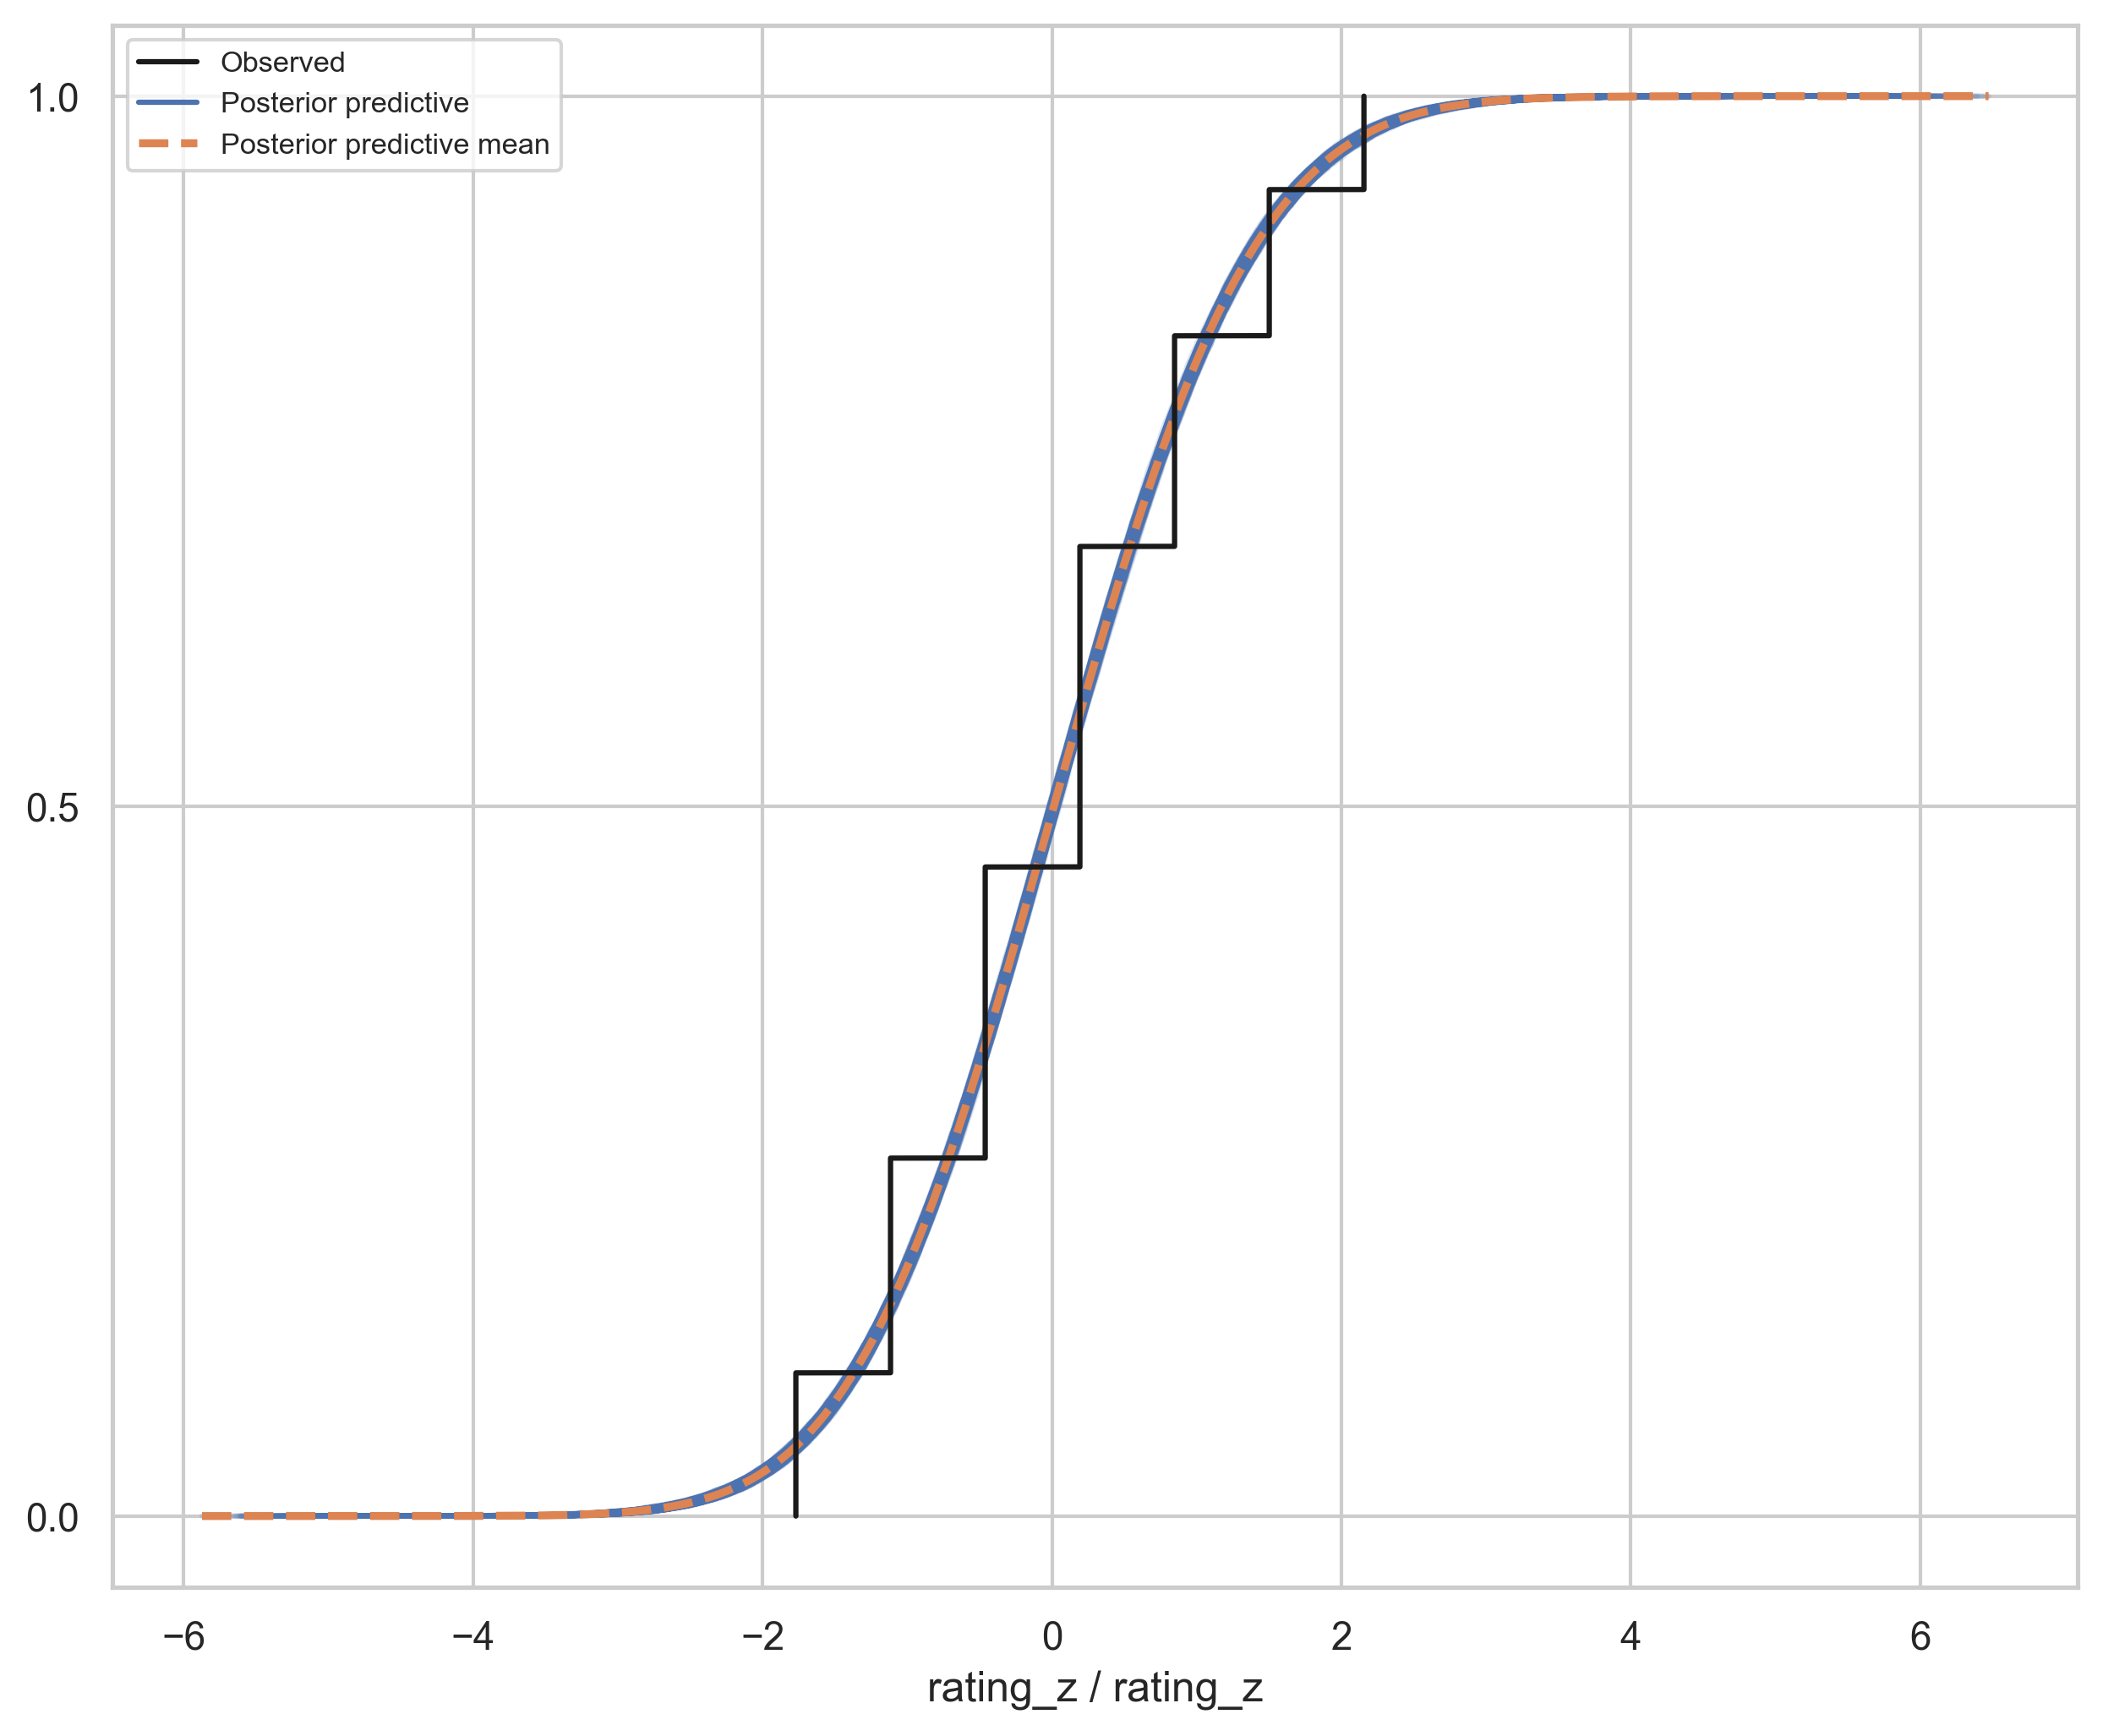

In [5]:
m_fic_filtered.predict(r_fic_filtered, kind='pps')
g = az.plot_ppc(r_fic_filtered, kind='cumulative')

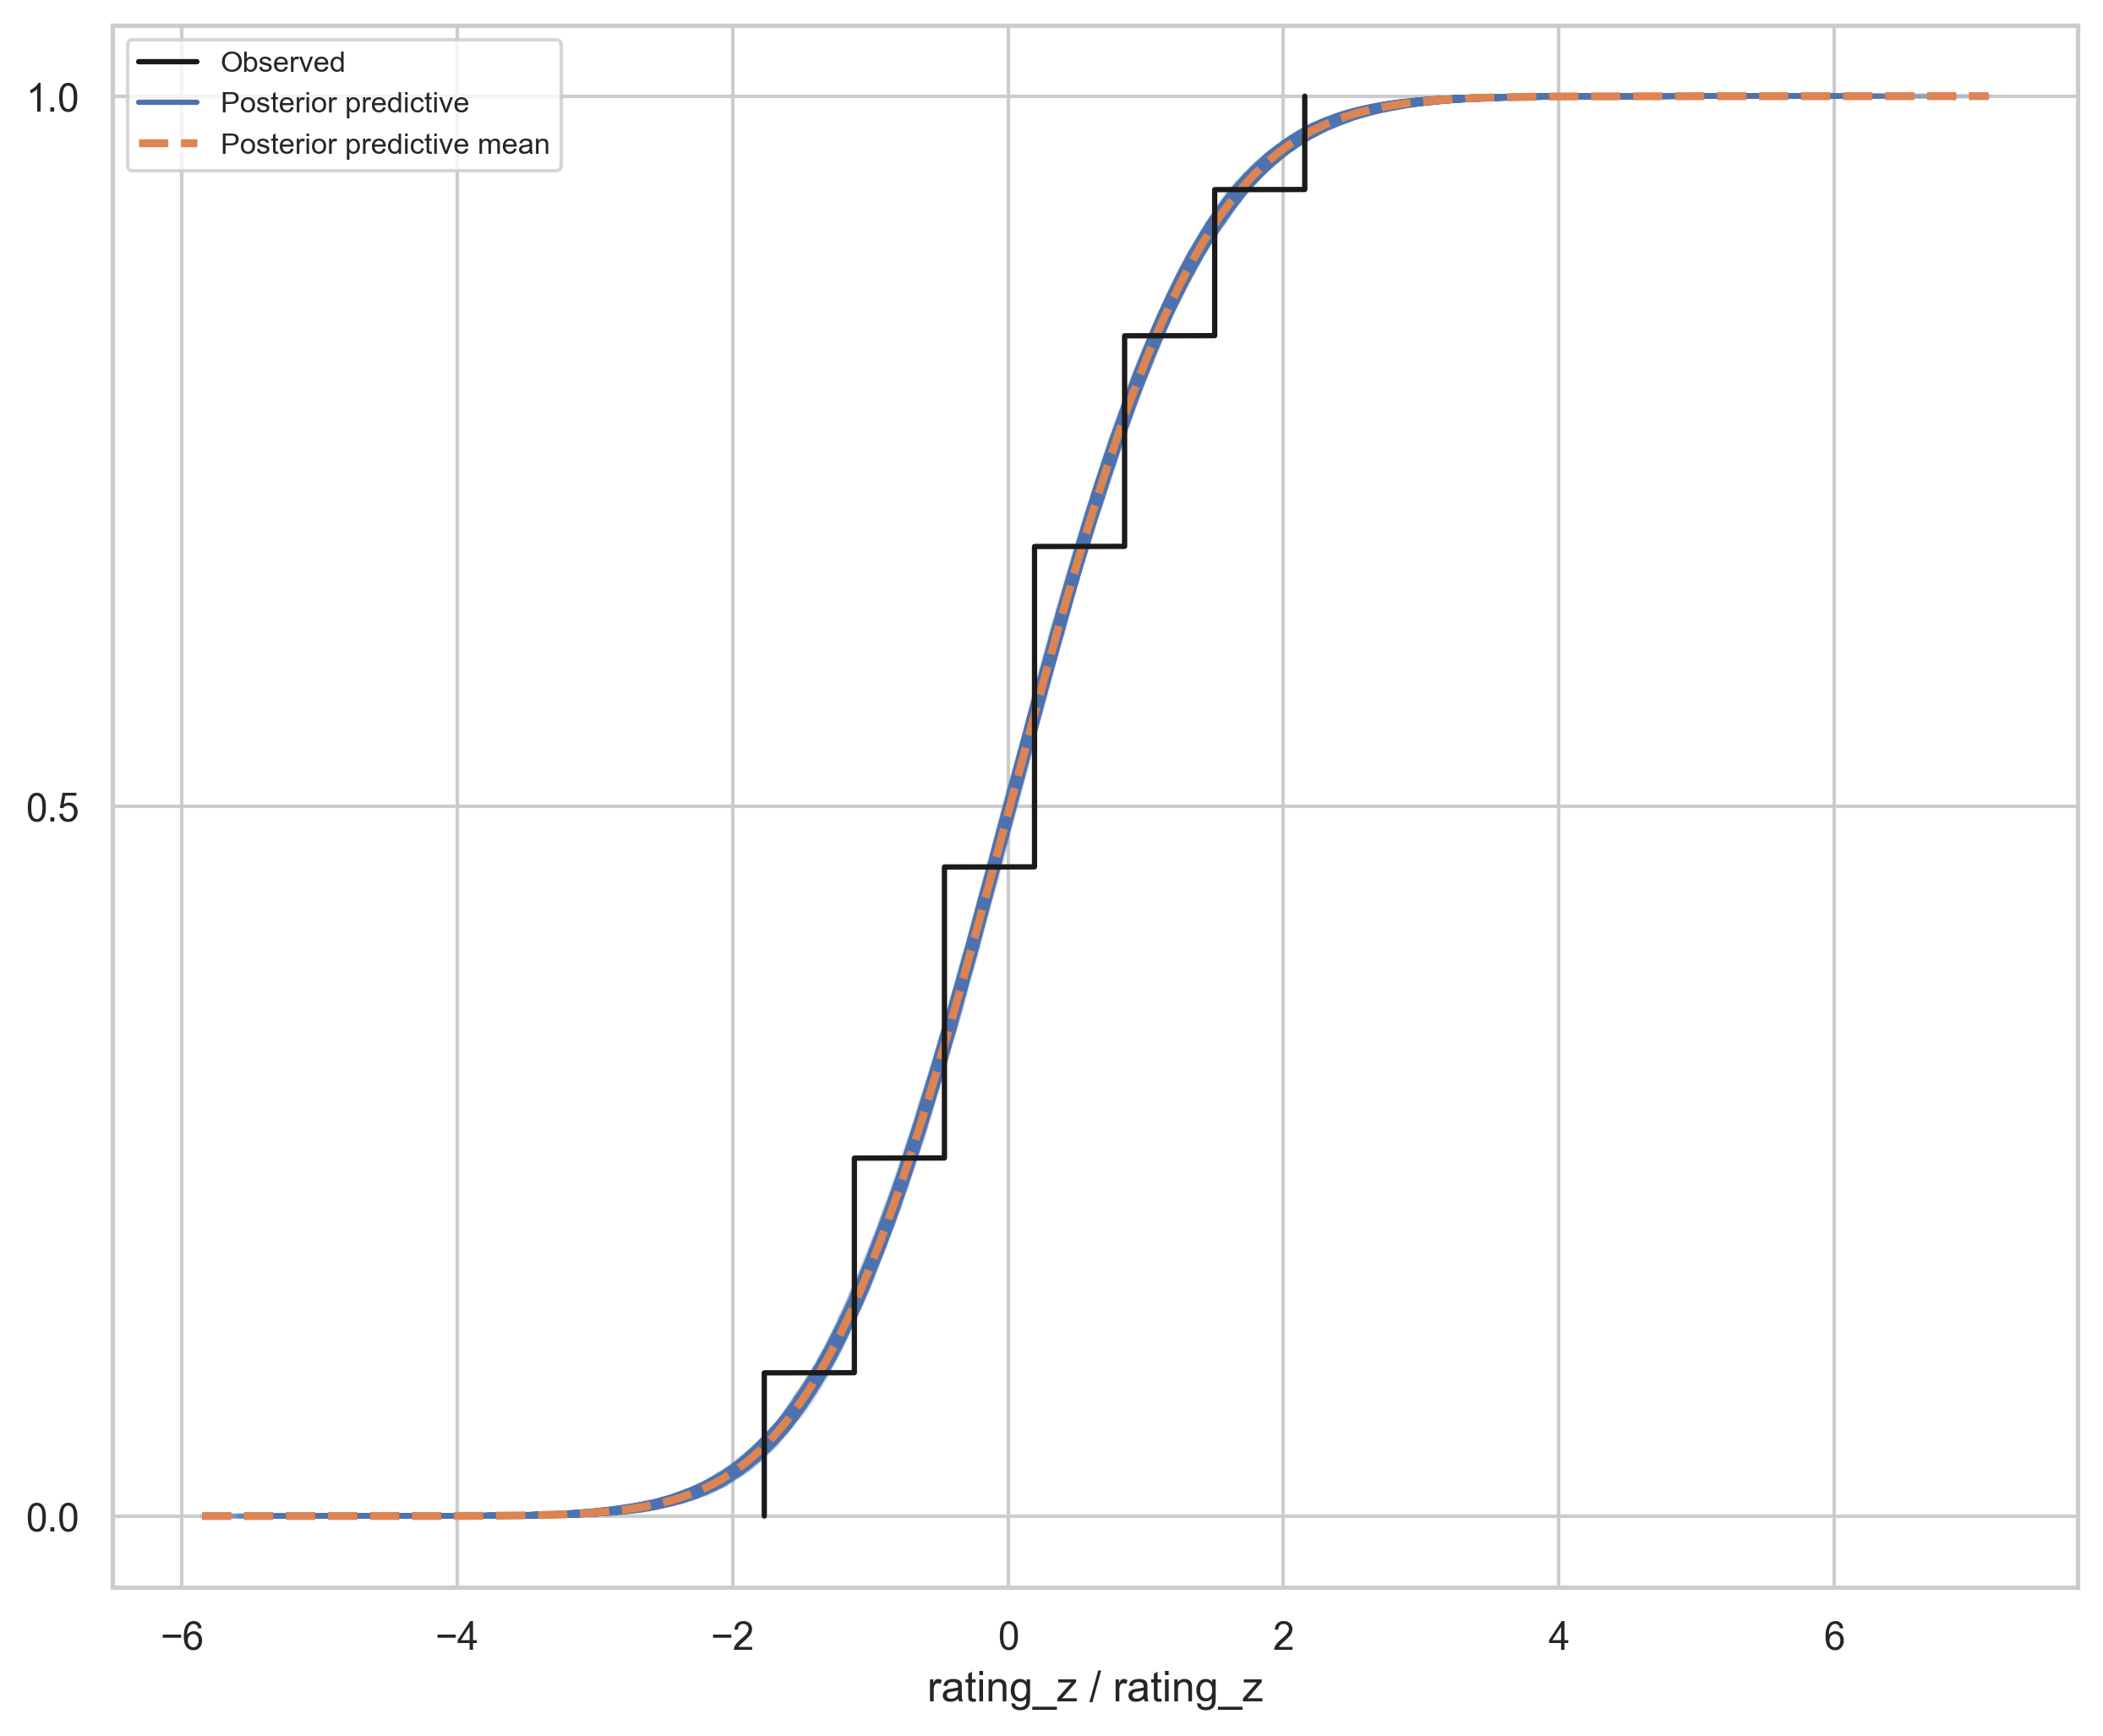

In [5]:
m_fic_noneighbors.predict(r_fic_noneighbors, kind='pps')
g = az.plot_ppc(r_fic_noneighbors, kind='cumulative')

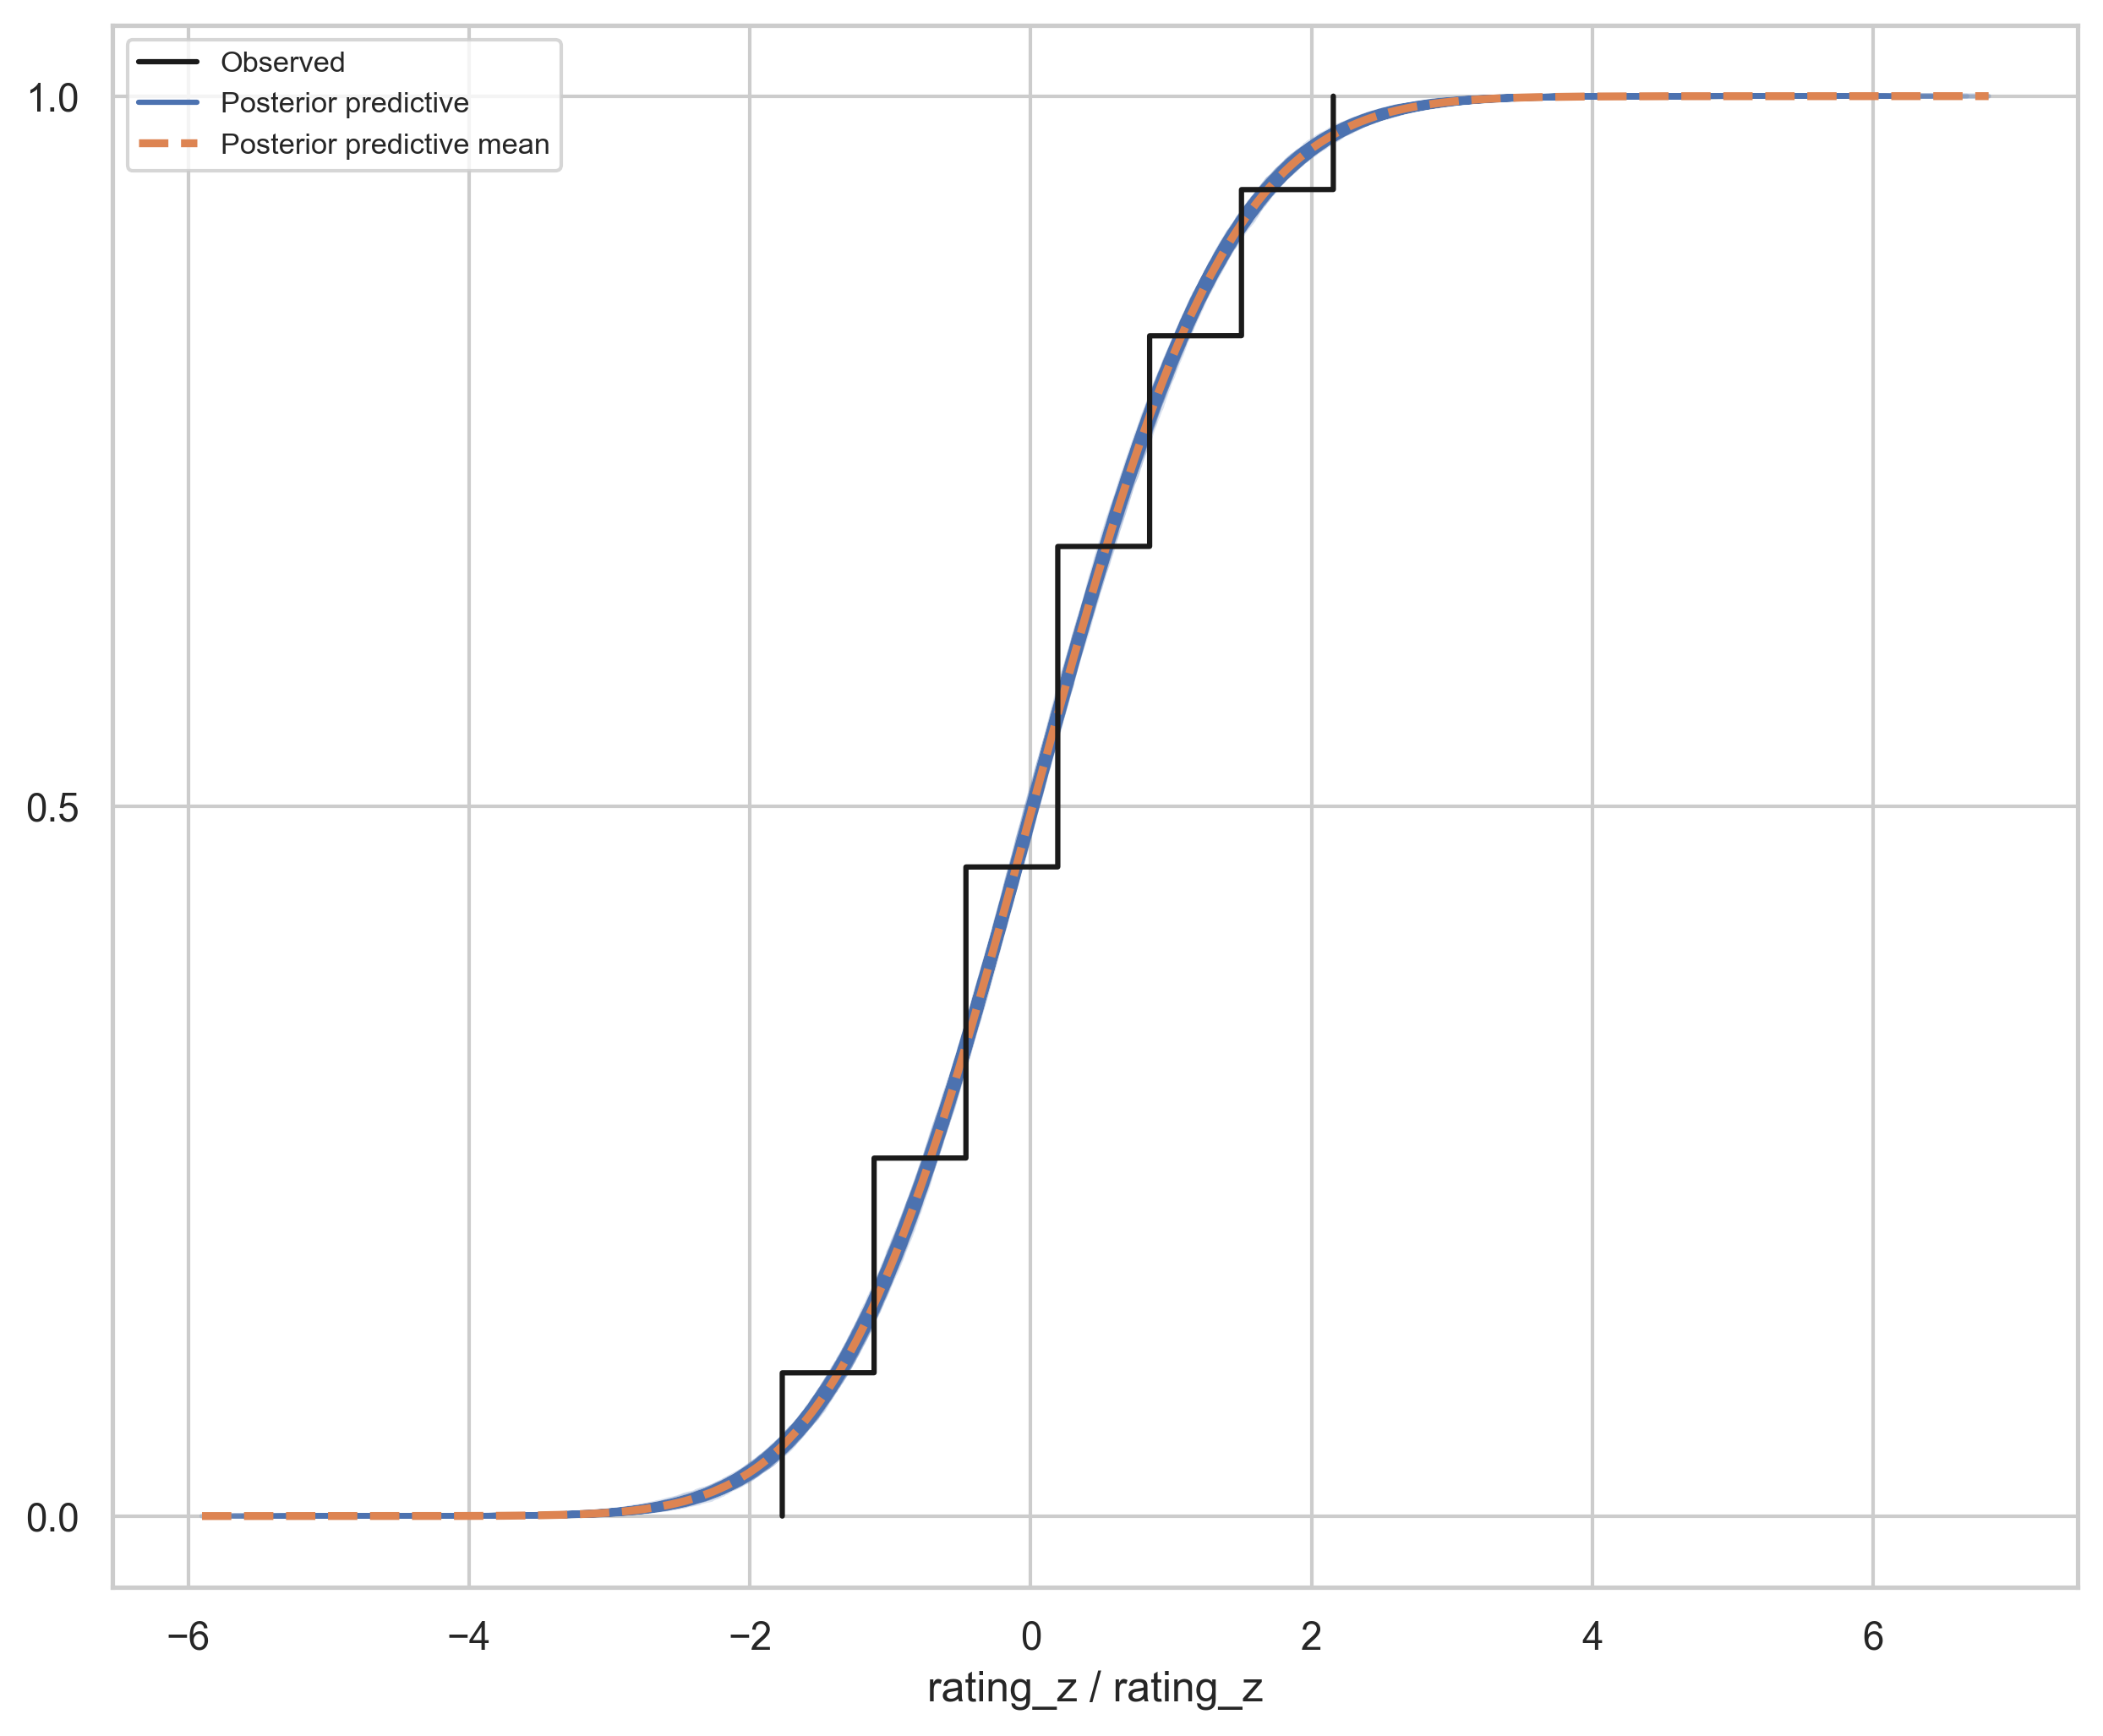

In [5]:
m_fic_nonames.predict(r_fic_nonames, kind='pps')
g = az.plot_ppc(r_fic_nonames, kind='cumulative')

# Convert notebook to html

In [6]:
convert_notebook('experiment_3')

Jupyter notebook `experiment_3` converted successfully.